In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pyproteonet

In [4]:
from pathlib import Path
import math

import pandas as pd
import numpy as np
import mpl_scatter_density
import matplotlib
from matplotlib import pyplot as plt
from pyproteonet.metrics.abundance_comparison import compare_columns
from matplotlib import pyplot as plt
import seaborn as sns
from seaborn import boxplot
from tqdm.auto import tqdm

from pyproteonet.data import Dataset
from pyproteonet.metrics.paired_testing import paired_wilcoxon_matrix
from pyproteonet.metrics.differential_expression import find_des

from utils.globals import method_label_map, dataset_label_map

eval_columns = ['mindet', 'minprob', 'median', 'knn', 'missforest', 'bpca', 'isvd', 'vae', 'dae', 'cf', 'iterative', 'gnn_imp']
EVAL_DATASETS = ['breast_cancer', 'blood_ddia', 'maxlfqbench', 'human_ecoli_ddia', 'prostate_cancer', 'crohns_fibrosis']

method_order = ['PEPerMINT', 'RF', 'BPCA', 'MICE', 'CF', 'Median', 'DAE', 'KNN', 'ISVD', 'VAE', 'MinDet', 'MinProb']

from matplotlib import colormaps
from matplotlib.colors import ListedColormap
PALETTE = ListedColormap(["orange",
                        '#178217',#g1
                        '#090953',#b1
                        '#26d926',#g2
                        '#1212a5',#b2
                        "#821717",#r1
                        '#2c2ce8',#b3
                        '#7de87d',#g3
                        '#7e7ef1',#b4
                        '#d1d1fa',#b5
                        "#d92626",#r2
                        "#e87d7d",#r3
                        ])
PALETTE
PALETTE = PALETTE.colors

# Load Datasets

In [5]:
from preprocessing import embed_sequences_t5_cached, create_masked_dataset, remove_all_missing
imp_datasets = {}

for ds_name in ['breast_cancer', 'prostate_cancer', 'crohns_fibrosis', 'maxlfqbench', 'blood_ddia', 'human_ecoli_ddia']:#['crohns_disease']:
    print(ds_name)
    ds = Dataset.load(f'data/datasets_imputed/{ds_name}')
    imp_datasets[ds_name] = ds

breast_cancer
prostate_cancer
crohns_fibrosis
maxlfqbench
blood_ddia
human_ecoli_ddia


In [10]:
ablation_datasets = {}
ablation_datasets['prostate_cancer'] = imp_datasets['prostate_cancer'].copy()
ablation_datasets['prostate_cancer_zero_sequence_embeddings'] = Dataset.load(f'data/datasets_experiments/prostate_cancer_zero_sequence_embeddings')
ablation_datasets['prostate_cancer_no_skip'] = Dataset.load(f'data/datasets_experiments/prostate_cancer_no_skip')
ablation_datasets['prostate_cancer_random_edges'] = Dataset.load(f'data/datasets_experiments/prostate_cancer_random_edges')
ablation_datasets['prostate_cancer_no_skip_random_edges'] = Dataset.load(f'data/datasets_experiments/prostate_cancer_no_skip_random_edges')

# Evaluation

## Dataset Characteristics

In [25]:
data = {
    '#Peptides': [],
    '#Proteins': [],
    '#Samples': [],
    'MissingnessCounts': [],
    'Mean': [],
    'Std': [],
    '% Missing Values': []
}
for ds_name, ds in imp_datasets.items():
    perc_missing = ds.values['peptide']['abundance']
    num_peps = ds.molecules['peptide'].shape[0]
    num_prots = ds.molecules['protein'].shape[0]
    num_samples = ds.num_samples
    perc_missing = perc_missing.isna().sum() / perc_missing.shape[0]
    data['#Peptides'].append(num_peps)
    data['#Proteins'].append(num_prots)
    data['#Samples'].append(num_samples)
    missingness_dist = ds.get_wf('peptide', 'abundance').count(axis=1).value_counts()
    data['MissingnessCounts'].append(str(dict(missingness_dist)))
    data['Mean'].append(ds.values['peptide']['abundance'].mean())
    data['Std'].append(ds.values['peptide']['abundance'].std())
    data['% Missing Values'].append(perc_missing * 100)
pd.DataFrame(data, index=imp_datasets.keys())

,#Peptides,#Proteins,#Samples,MissingnessCounts,Mean,Std,% Missing Values
breast_cancer_20,111966,13851,20,"{1: 29721, 2: 15285, 3: 10379, 4: 7918, 5: 654...",16.197706,1.545235,71.30754


## Plots

In [5]:
# Calculate the ids of the values to evaluate for each dataset and missingness threshold
# thresholds = [1.0, 0.75, 0.5, 0.25]
# rows, cols = len(imp_datasets), len(thresholds)

# ids_map = {}
# for row, (ds_name, ds_name) in enumerate(imp_datasets.items()):
#     ids_map[ds_name] = {}
#     for col, thresh in enumerate(thresholds):
#         missingness = ds_name.get_wf('peptide', 'abundance')
#         missingness = missingness[missingness.isna().sum(axis=1) / missingness.shape[1] <= thresh].index
#         gt_column = 'abundance_gt'
#         ids = ds_name.values['peptide'][gt_column]
#         ids = ids[~ids.isna() & ds_name.values['peptide']['abundance'].isna()].index
#         ids = ids[ids.get_level_values('id').isin(missingness)]
#         ids_map[ds_name][thresh] = ids

## Overall Barplot

In [5]:
rmse_dfs = []
mae_dfs = []
with tqdm(total=len(imp_datasets)) as pbar:
    for ds_name, ds in imp_datasets.items():
        gt_column = 'abundance_gt'
        ids = ds.values['peptide'][gt_column]
        ids = ids[~ids.isna() & ds.values['peptide']['abundance'].isna()].index
        #ids = ids[ids.get_level_values('id').isin(not_all_missing)]
        metric_df = compare_columns(dataset=ds, molecule='peptide', columns=eval_columns, comparison_column=gt_column,
                                    metric='RMSE', logarithmize=False, ids=ids, per_sample=True, ignore_missing=False)
        metric_df['dataset'] = ds_name
        rmse_dfs.append(metric_df)

        df = ds.values['peptide'].df
        df = df.loc[ids]
        ae = ((df - df[[gt_column]].values).abs())
        ae = ae[eval_columns]
        mae = ae.mean()
        mae_df = pd.DataFrame({'metric':mae})
        mae_df.index.set_names('column', inplace=True)
        mae_df = mae_df.reset_index()
        mae_df['dataset'] = ds_name
        mae_dfs.append(mae_df)
        pbar.update(1)
rmse_dfs= pd.concat(rmse_dfs)
mae_dfs = pd.concat(mae_dfs)

  0%|          | 0/6 [00:00<?, ?it/s]

In [6]:
# method_order = list(rmse_dfs.groupby('column').mean().sort_values('metric').index)
# method_order = [method_label_map[m] for m in method_order]
method_order = ['PEPerMINT', 'RF', 'BPCA', 'MICE', 'CF', 'Median', 'DAE', 'KNN', 'ISVD', 'VAE', 'MinDet', 'MinProb']

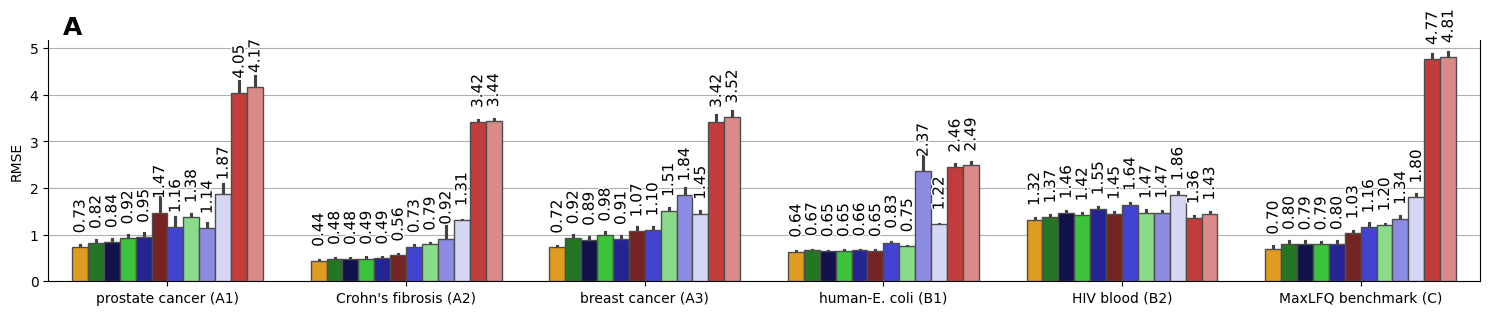

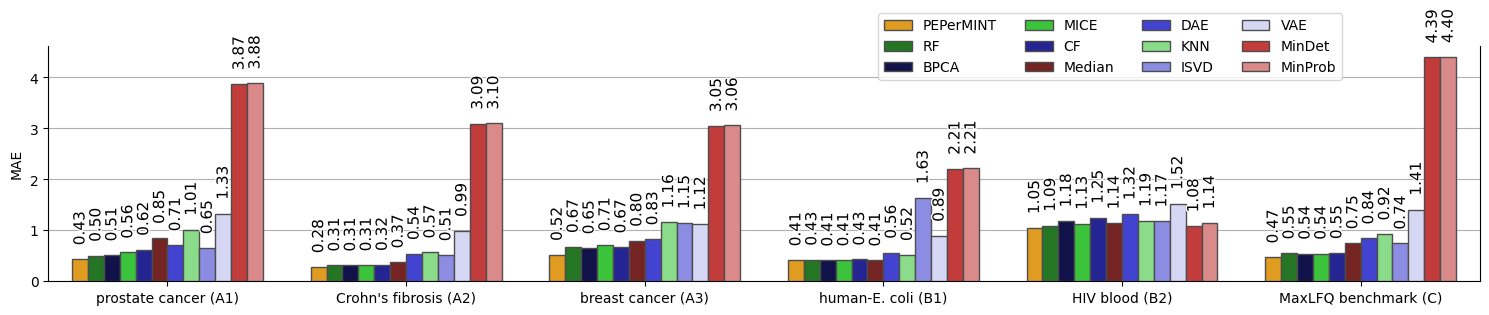

In [25]:
import matplotlib.patheffects as PathEffects

for df, ylabel, fig_name in [(rmse_dfs.copy(), 'RMSE', 'sample_wise_rmse_bar'), (mae_dfs.copy(), 'MAE', 'dataset_mae_bar')]:
   fig, ax = plt.subplots(1, 1, figsize=(15, 3.25))
   df['column'] = df['column'].map(method_label_map)
   df['dataset'] = df['dataset'].map(dataset_label_map)
   sns.barplot(df, y='metric', x='dataset', hue='column', ax=ax, hue_order=method_order,  linewidth=1.0, edgecolor="0.3", palette=PALETTE,
               order=[dataset_label_map[d] for d in ["prostate_cancer", "crohns_fibrosis", "breast_cancer", "human_ecoli_ddia", "blood_ddia", "maxlfqbench"]],
               zorder=3)
   ax.set_ylabel(ylabel)
   ax.grid(axis='y', zorder=0)
   ax.spines['top'].set_visible(False)
   for container in ax.containers:
      ax.bar_label(container, fmt='%.2f', label_type='edge', rotation = 90, padding=10, fontsize=11, path_effects=[PathEffects.withStroke(linewidth=2, foreground='w')])#15.1)
   ticks = [k.get_text() for k  in ax.get_xticklabels()]
   ax.set_xticks(ax.get_xticks()) # Workaround to silence a warning
   ax.set_xticklabels(ticks, ha='center')
   ax.legend(loc='lower left', bbox_to_anchor=(0.575, 0.825), ncol=4, fontsize=10)
   if fig_name == 'sample_wise_rmse_bar':
      ax.legend().remove()
   ax.set_xlabel('')
   if fig_name == 'sample_wise_rmse_bar':
      ax.text(s='A', x=0.01, y=1.025, transform=ax.transAxes, fontsize=18, fontweight='bold')
   #ax.set_ylim(0, 5.0)
   fig.tight_layout()
   fig.savefig(f'figures/{fig_name}.pdf')

## Performance across Missingness Thresholds

In [7]:
thresh_rmse_dfs = dict()
intervals = [(1.0, 0.75), (0.75, 0.5), (0.5, 0.25), (0.25, 0.0)]
with tqdm(total=len(imp_datasets) * len(intervals)) as pbar:
    for ds_name, ds in imp_datasets.items():
        rmse_df = []
        for inter in intervals:
            ids = ds.values['peptide']['abundance_gt']
            ids = ids[~ids.isna() & ds.values['peptide']['abundance'].isna()].index
            missingness = ds.get_wf('peptide', 'abundance')
            missingness = missingness[(missingness.isna().sum(axis=1) / missingness.shape[1] <= inter[0]) & 
                                      (missingness.isna().sum(axis=1) / missingness.shape[1] >= inter[1])].index
            ids = ids[ids.get_level_values('id').isin(missingness)]
            print(f'{ds_name}, {inter}, {ids.shape[0]}')
            metric_df = compare_columns(dataset=ds, molecule='peptide', columns=eval_columns, comparison_column=gt_column,
                                        metric='RMSE', logarithmize=False, ids=ids, per_sample=True, ignore_missing=False)
            metric_df['interval_lower'] = inter[1]
            metric_df['interval_upper'] = inter[0]
            rmse_df.append(metric_df)
            pbar.update(1)
        rmse_df= pd.concat(rmse_df)
        thresh_rmse_dfs[ds_name] = rmse_df

  0%|          | 0/24 [00:00<?, ?it/s]

breast_cancer, (1.0, 0.75), 10380
breast_cancer, (0.75, 0.5), 13676
breast_cancer, (0.5, 0.25), 17456
breast_cancer, (0.25, 0.0), 9205
prostate_cancer, (1.0, 0.75), 5742
prostate_cancer, (0.75, 0.5), 17368
prostate_cancer, (0.5, 0.25), 28769
prostate_cancer, (0.25, 0.0), 5197
crohns_fibrosis, (1.0, 0.75), 1907
crohns_fibrosis, (0.75, 0.5), 5913
crohns_fibrosis, (0.5, 0.25), 18152
crohns_fibrosis, (0.25, 0.0), 26681
maxlfqbench, (1.0, 0.75), 604
maxlfqbench, (0.75, 0.5), 4742
maxlfqbench, (0.5, 0.25), 11750
maxlfqbench, (0.25, 0.0), 12088
blood_ddia, (1.0, 0.75), 3592
blood_ddia, (0.75, 0.5), 3043
blood_ddia, (0.5, 0.25), 1594
blood_ddia, (0.25, 0.0), 630
human_ecoli_ddia, (1.0, 0.75), 18770
human_ecoli_ddia, (0.75, 0.5), 24010
human_ecoli_ddia, (0.5, 0.25), 22056
human_ecoli_ddia, (0.25, 0.0), 12728


In [15]:
from matplotlib import patheffects as PathEffects

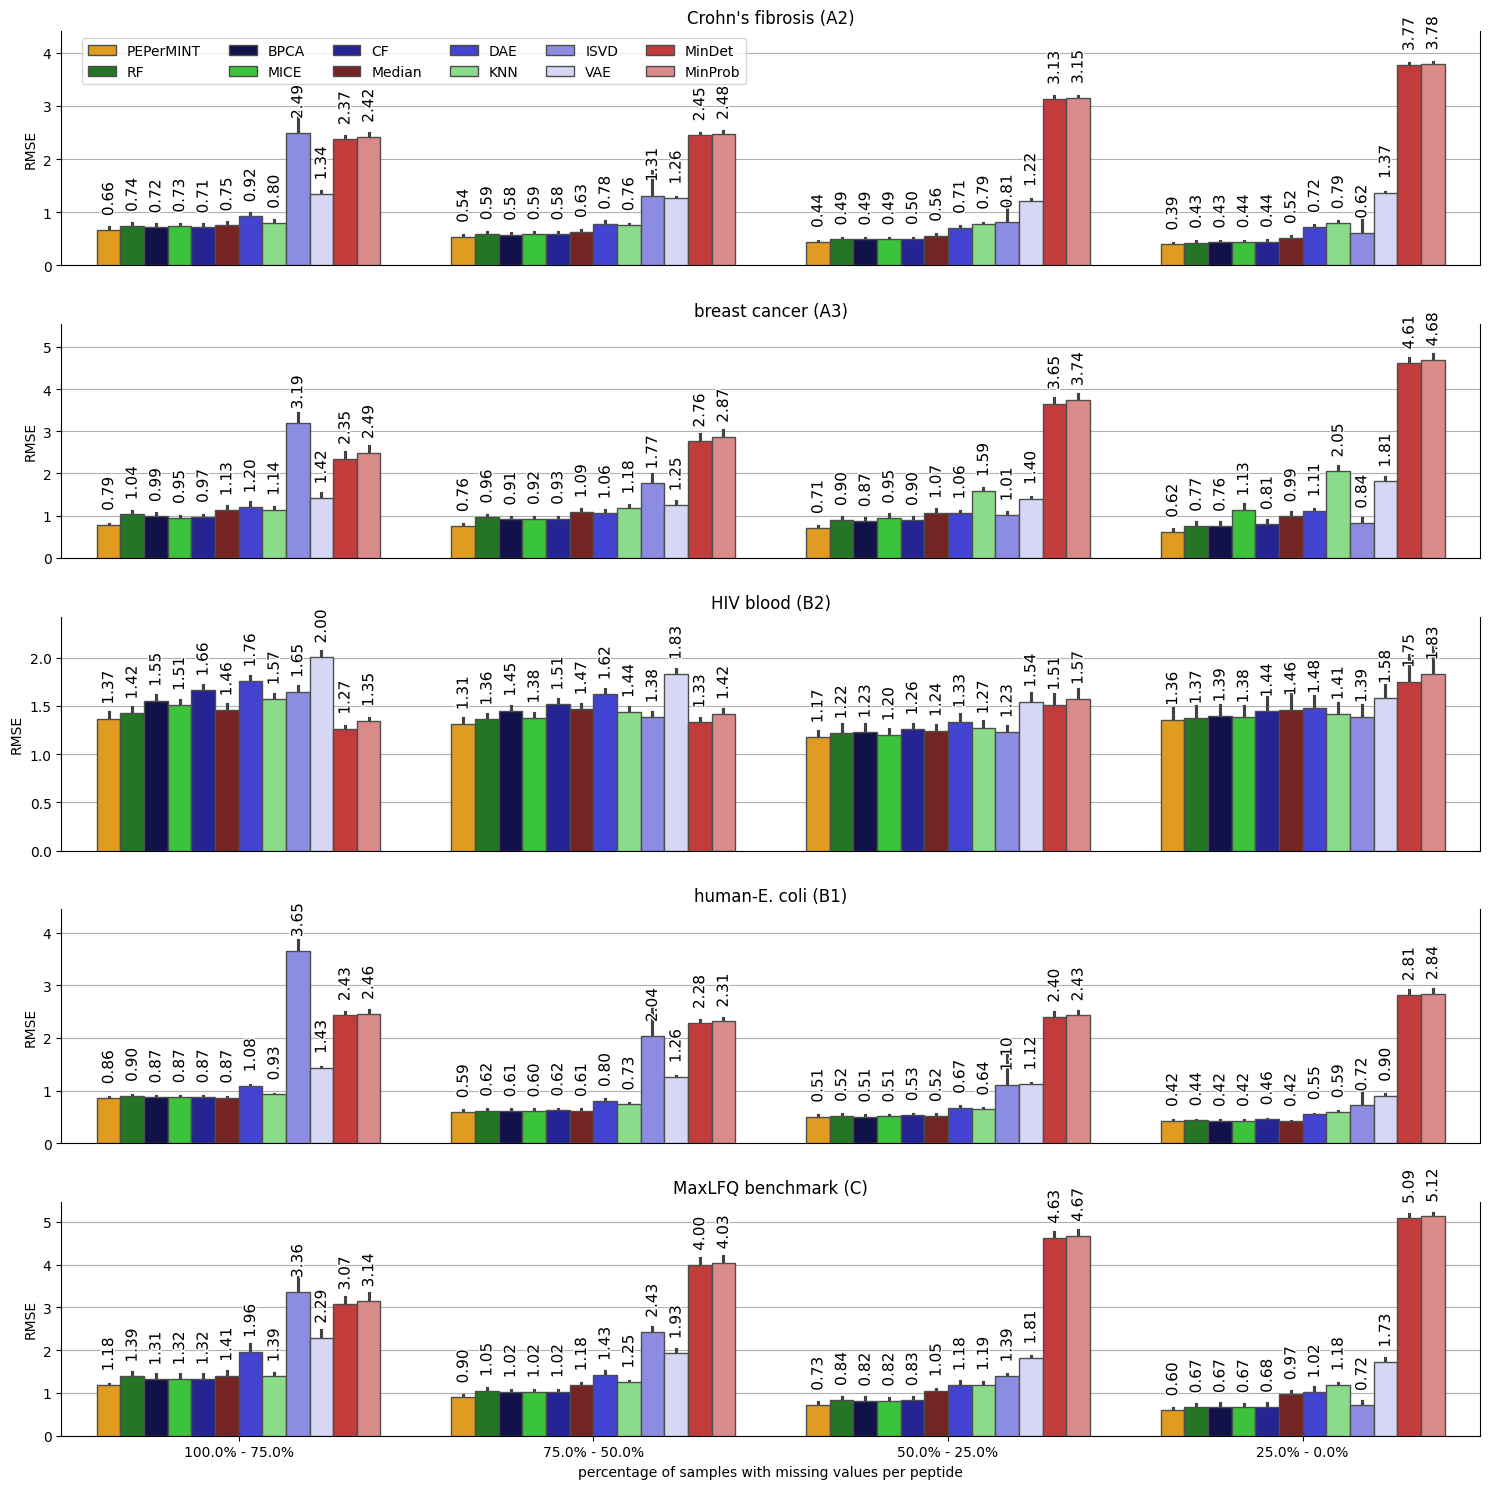

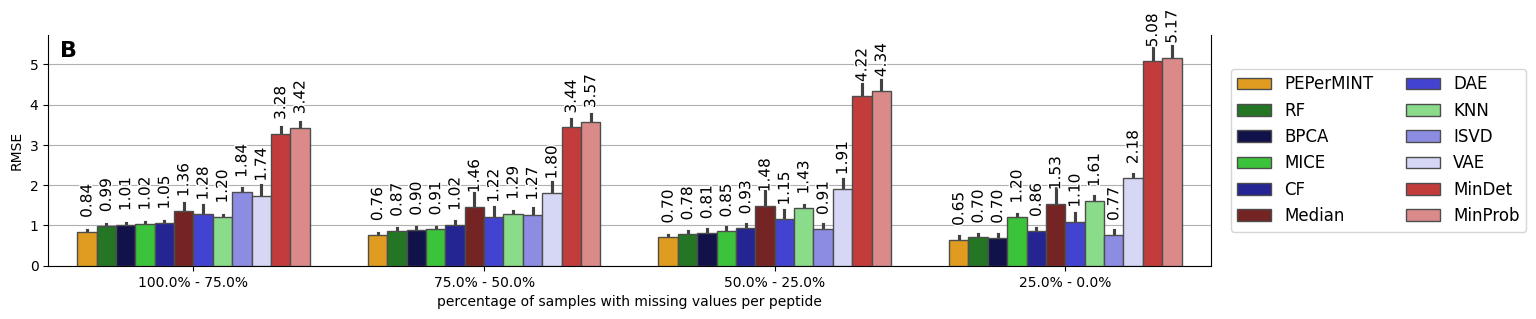

In [28]:
ds_names = ['prostate_cancer', 'crohns_fibrosis', 'breast_cancer', 'blood_ddia', 'human_ecoli_ddia', 'maxlfqbench']

num_rows = len(ds_names) - 1
fig, axs = plt.subplots(num_rows, 1, figsize=(15, 3*num_rows))
fig_main, ax_main = plt.subplots(1, 1, figsize=(15, 3))
col = -1
for ds_name in ds_names:
   ds = imp_datasets[ds_name]
   df = thresh_rmse_dfs[ds_name].copy()
   if ds_name == 'prostate_cancer':
      ax = ax_main
   else:
      col += 1
      ax = axs[col]
   df['column'] = df['column'].map(method_label_map)
   df['interval'] = (df['interval_upper']*100).astype(str) + '% - ' + (df['interval_lower']*100).astype(str) + '%'
   sns.barplot(df, y='metric', x='interval', hue='column', ax=ax, hue_order=method_order,  linewidth=1.0, edgecolor="0.3", palette=PALETTE, zorder=10)
   ax.set_ylabel('RMSE')
   for container in ax.containers:
      ax.bar_label(container, fmt='%.2f', label_type='edge', rotation = 90, padding=10,
                    fontsize=11, path_effects=[PathEffects.withStroke(linewidth=2, foreground='w')])#15.1)
   ticks = [k.get_text() for k  in ax.get_xticklabels()]
   ax.grid(axis='y', zorder=1)
   ax.spines['top'].set_visible(False)
   ax.set_xticks(ax.get_xticks()) # Workaround to silence a warning
   ax.set_xticklabels(ticks, ha='center')
   ax.set_xlabel('percentage of samples with missing values per peptide')
   ax.set_title(dataset_label_map[ds_name])
   if ds_name == 'prostate_cancer':
      ax.set_title('')
      ax.text(s='B', x=0.01, y=0.905, transform=ax.transAxes, fontsize=16, fontweight='bold')
   if col==0 and ds_name != 'prostate_cancer':
      ax.legend(loc='upper left', bbox_to_anchor=(0.01, 1.0), ncol=6, fontsize=10)
   elif ds_name == 'prostate_cancer':
       ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), ncol=2, fontsize=12)
   else:
      ax.legend().remove()
   if col<len(ds_names)-2 and ds_name != 'prostate_cancer':
      ax.set_xticks([])
      ax.set_xlabel('')
      ax.margins(y=0.15) 
fig.tight_layout()
fig.savefig(f'figures/sample_wise_rmse_bar_stratified_supplement.pdf', bbox_inches='tight')
fig_main.savefig(f'figures/sample_wise_rmse_bar_stratified_main.pdf', bbox_inches='tight')

In [ ]:
sample_rmse_results = {}
dataset_ae_results = {}
print('Calculating metrics...')
with tqdm(total=rows*cols) as pbar:
    for row, (ds_name, ds_name) in enumerate(imp_datasets.items()):
        sample_rmse_results[ds_name] = {}
        dataset_ae_results[ds_name] = {}
        for col, thresh in enumerate(thresholds):
            ids = ids_map[ds_name][thresh]
            df = ds_name.values['peptide'].df.loc[ids, eval_columns]
            # Just a safety check, there should be no missing values after imputation
            assert not df.isna().any().any()
            df = df[~df.isna().any(axis=1)]
            # molecule AE and sample wise RMSE plots
            metric_df = compare_columns(dataset=ds_name, molecule='peptide', columns=eval_columns, comparison_column=gt_column,
                                        metric='RMSE', logarithmize=False, ids=ids, per_sample=True, ignore_missing=False)
            metric_df['dataset'] = ds_name
            sample_rmse_results[ds_name][thresh] = metric_df
            df = ds_name.values['peptide'].df
            df = df.loc[ids]
            ae = ((df - df[[gt_column]].values).abs())
            ae = ae[eval_columns]
            mae = ae.mean()
            mae_df = pd.DataFrame({'metric':mae})
            mae_df.index.set_names('column', inplace=True)
            mae_df = mae_df.reset_index()
            mae_df['dataset'] = ds_name
            dataset_ae_results[ds_name][thresh] = mae_df
            pbar.update(1)

In [ ]:
ds_names = ['prostate_cancer', 'crohns_fibrosis', 'breast_cancer', 'blood_ddia', 'human_ecoli_ddia', 'maxlfqbench']

num_rows = len(ds_names) - 1
fig, axs = plt.subplots(num_rows, 1, figsize=(15, 3*num_rows))
fig_main, ax_main = plt.subplots(1, 1, figsize=(15, 2.5))
col = -1
for ds_name in ds_names:
   ds = imp_datasets[ds_name]
   df = thresh_rmse_dfs[ds_name].copy()
   if ds_name == 'prostate_cancer':
      ax = ax_main
   else:
      col += 1
      ax = axs[col]
   df['column'] = df['column'].map(method_label_map)
   df['interval'] = (df['interval_upper']*100).astype(str) + '% - ' + (df['interval_lower']*100).astype(str) + '%'
   sns.barplot(df, y='metric', x='interval', hue='column', ax=ax, hue_order=method_order,  linewidth=1.0, edgecolor="0.3", palette=PALETTE)
   ax.set_ylabel('RMSE')
   for container in ax.containers:
      ax.bar_label(container, fmt='%.2f', label_type='edge', rotation = 90, padding=10,
                    fontsize=11, path_effects=[PathEffects.withStroke(linewidth=2, foreground='w')])#15.1)
   ticks = [k.get_text() for k  in ax.get_xticklabels()]
   ax.grid(axis='y')
   ax.spines['top'].set_visible(False)
   ax.set_xticks(ax.get_xticks()) # Workaround to silence a warning
   ax.set_xticklabels(ticks, ha='center')
   ax.set_xlabel('percentage of samples with missing values per peptide')
   ax.set_title(dataset_label_map[ds_name])
   if ds_name == 'prostate_cancer':
      ax.set_title('')
      ax.text(s='B', x=0.01, y=0.905, transform=ax.transAxes, fontsize=16, fontweight='bold')
   if col==0 and ds_name != 'prostate_cancer':
      ax.legend(loc='upper left', bbox_to_anchor=(0.01, 1.0), ncol=6, fontsize=10)
   else:
      ax.legend().remove()
   if col<len(ds_names)-2 and ds_name != 'prostate_cancer':
      ax.set_xticks([])
      ax.set_xlabel('')
      ax.margins(y=0.15) 
fig.tight_layout()
fig.savefig(f'figures/sample_wise_rmse_bar_stratified_supplement.pdf', bbox_inches='tight')
fig_main.savefig(f'figures/sample_wise_rmse_bar_stratified_main.pdf', bbox_inches='tight')

## Other Abundance Evaluations

In [76]:
#Generate the Bar and Boxplots

sample_rmse_results = {}
dataset_ae_results = {}
print('Calculating metrics...')
with tqdm(total=rows*cols) as pbar:
    for row, (ds_name, ds_name) in enumerate(imp_datasets.items()):
        sample_rmse_results[ds_name] = {}
        dataset_ae_results[ds_name] = {}
        for col, thresh in enumerate(thresholds):
            ids = ids_map[ds_name][thresh]
            df = ds_name.values['peptide'].df.loc[ids, eval_columns]
            # Just a safety check, there should be no missing values after imputation
            assert not df.isna().any().any()
            df = df[~df.isna().any(axis=1)]
            # molecule AE and sample wise RMSE plots
            metric_df = compare_columns(dataset=ds_name, molecule='peptide', columns=eval_columns, comparison_column=gt_column,
                                        metric='RMSE', logarithmize=False, ids=ids, per_sample=True, ignore_missing=False)
            metric_df['dataset'] = ds_name
            sample_rmse_results[ds_name][thresh] = metric_df
            df = ds_name.values['peptide'].df
            df = df.loc[ids]
            ae = ((df - df[[gt_column]].values).abs())
            ae = ae[eval_columns]
            mae = ae.mean()
            mae_df = pd.DataFrame({'metric':mae})
            mae_df.index.set_names('column', inplace=True)
            mae_df = mae_df.reset_index()
            mae_df['dataset'] = ds_name
            dataset_ae_results[ds_name][thresh] = mae_df
            pbar.update(1)

Calculating metrics...


  0%|          | 0/24 [00:00<?, ?it/s]

In [77]:
dataset_mae_dfs = dict()
sample_rmse_dfs = dict()
for thresh in thresholds:
    dataset_mae_dfs[thresh] = pd.concat([metric[thresh] for metric in dataset_ae_results.values()])
    sample_rmse_dfs[thresh] = pd.concat([metric[thresh] for metric in sample_rmse_results.values()])

Text(0.5, 0, '')

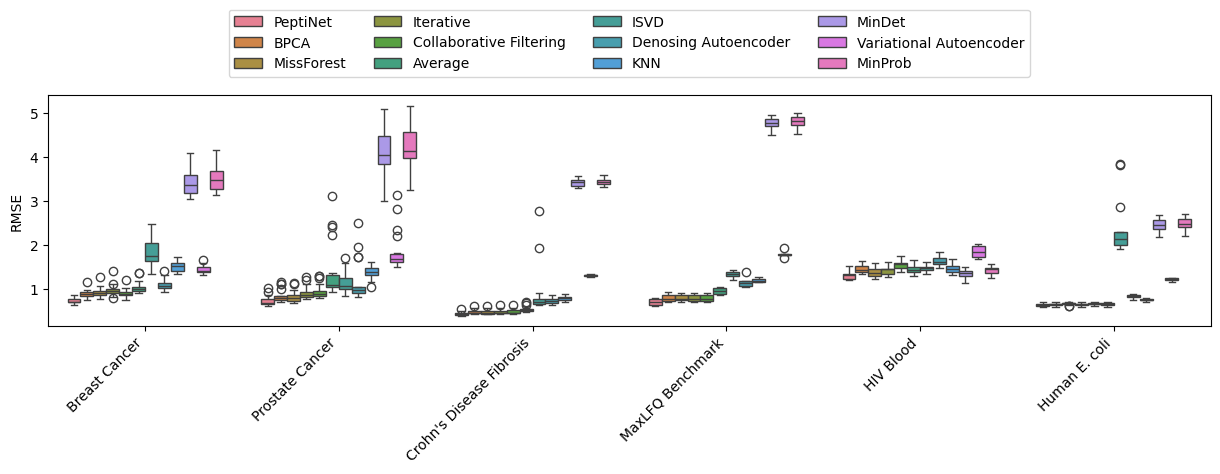

Plotting...
1.0
0.75
0.5
0.25


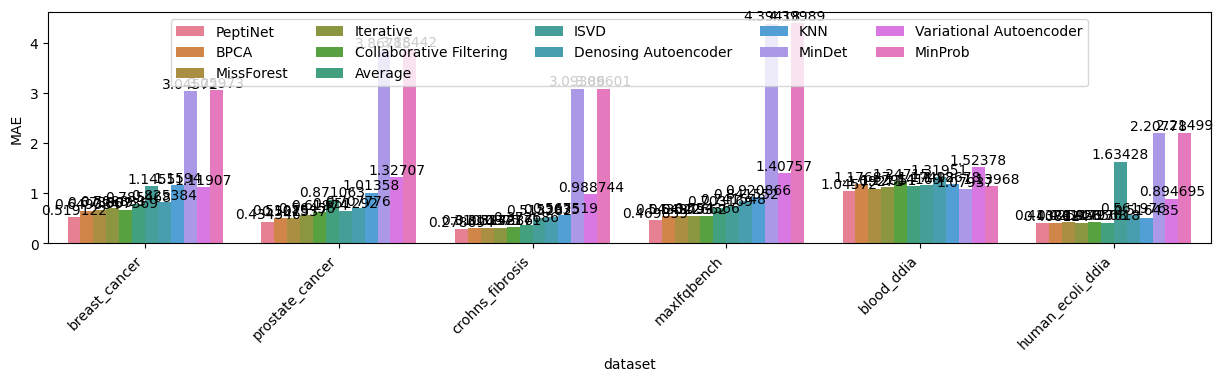

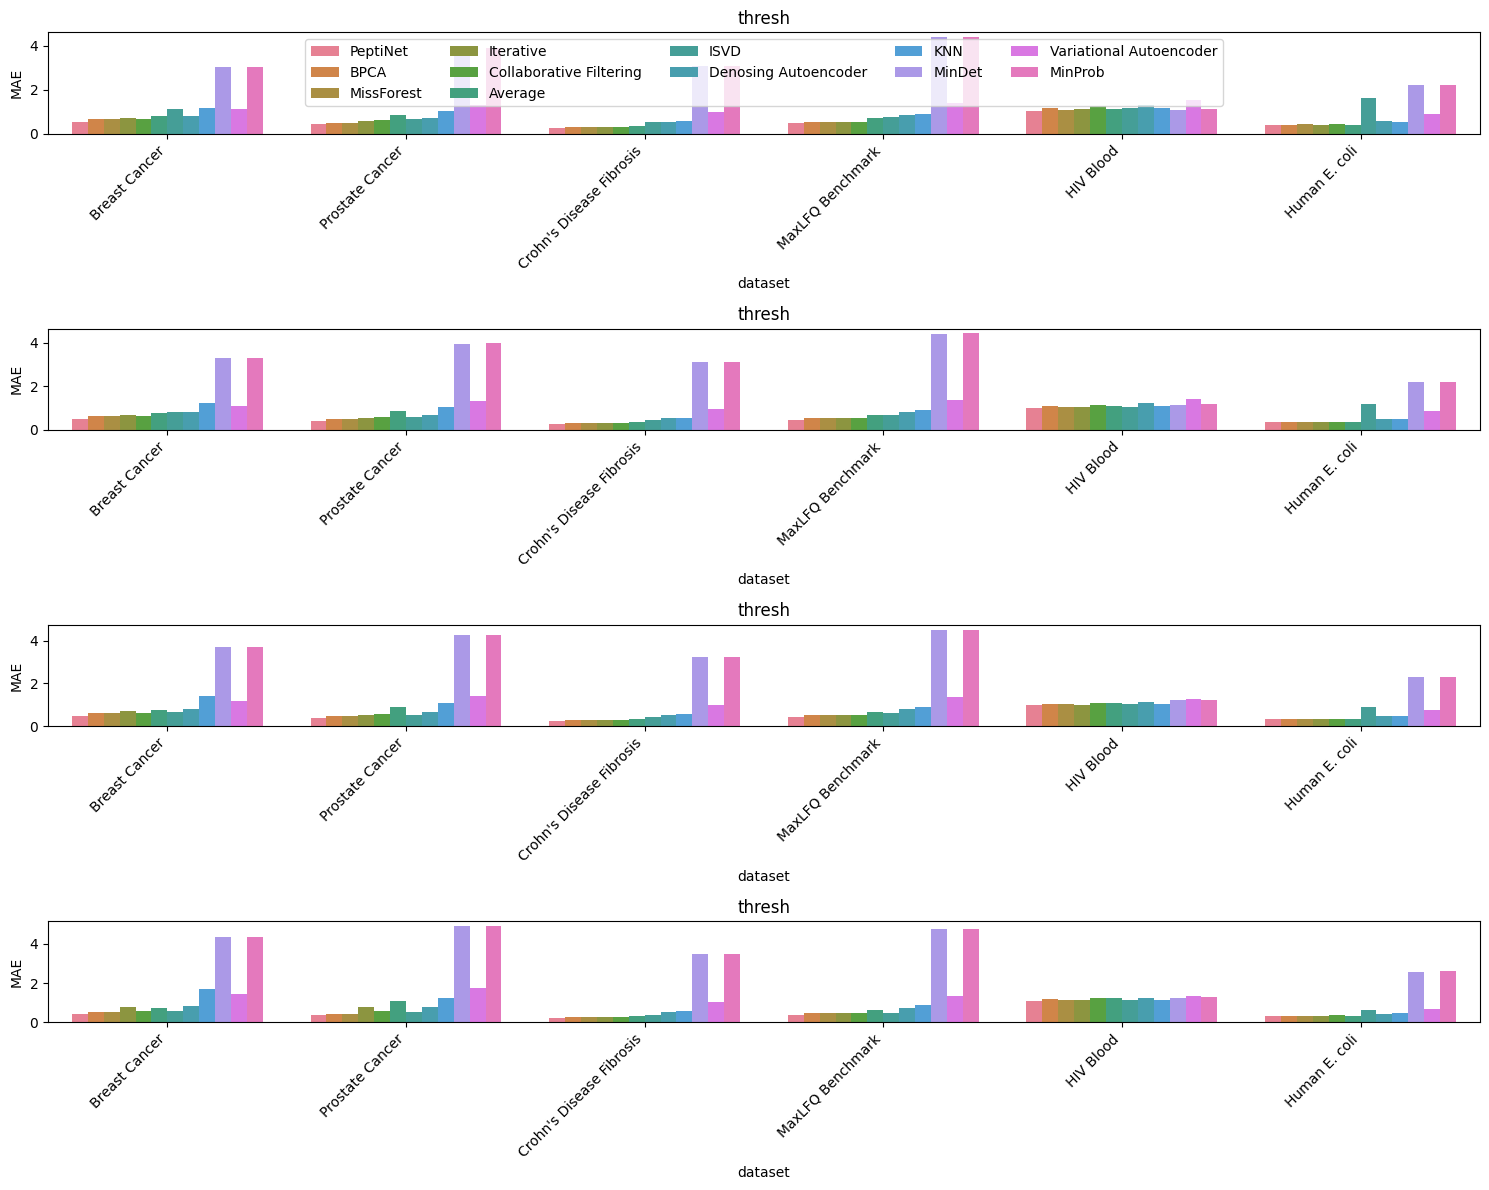

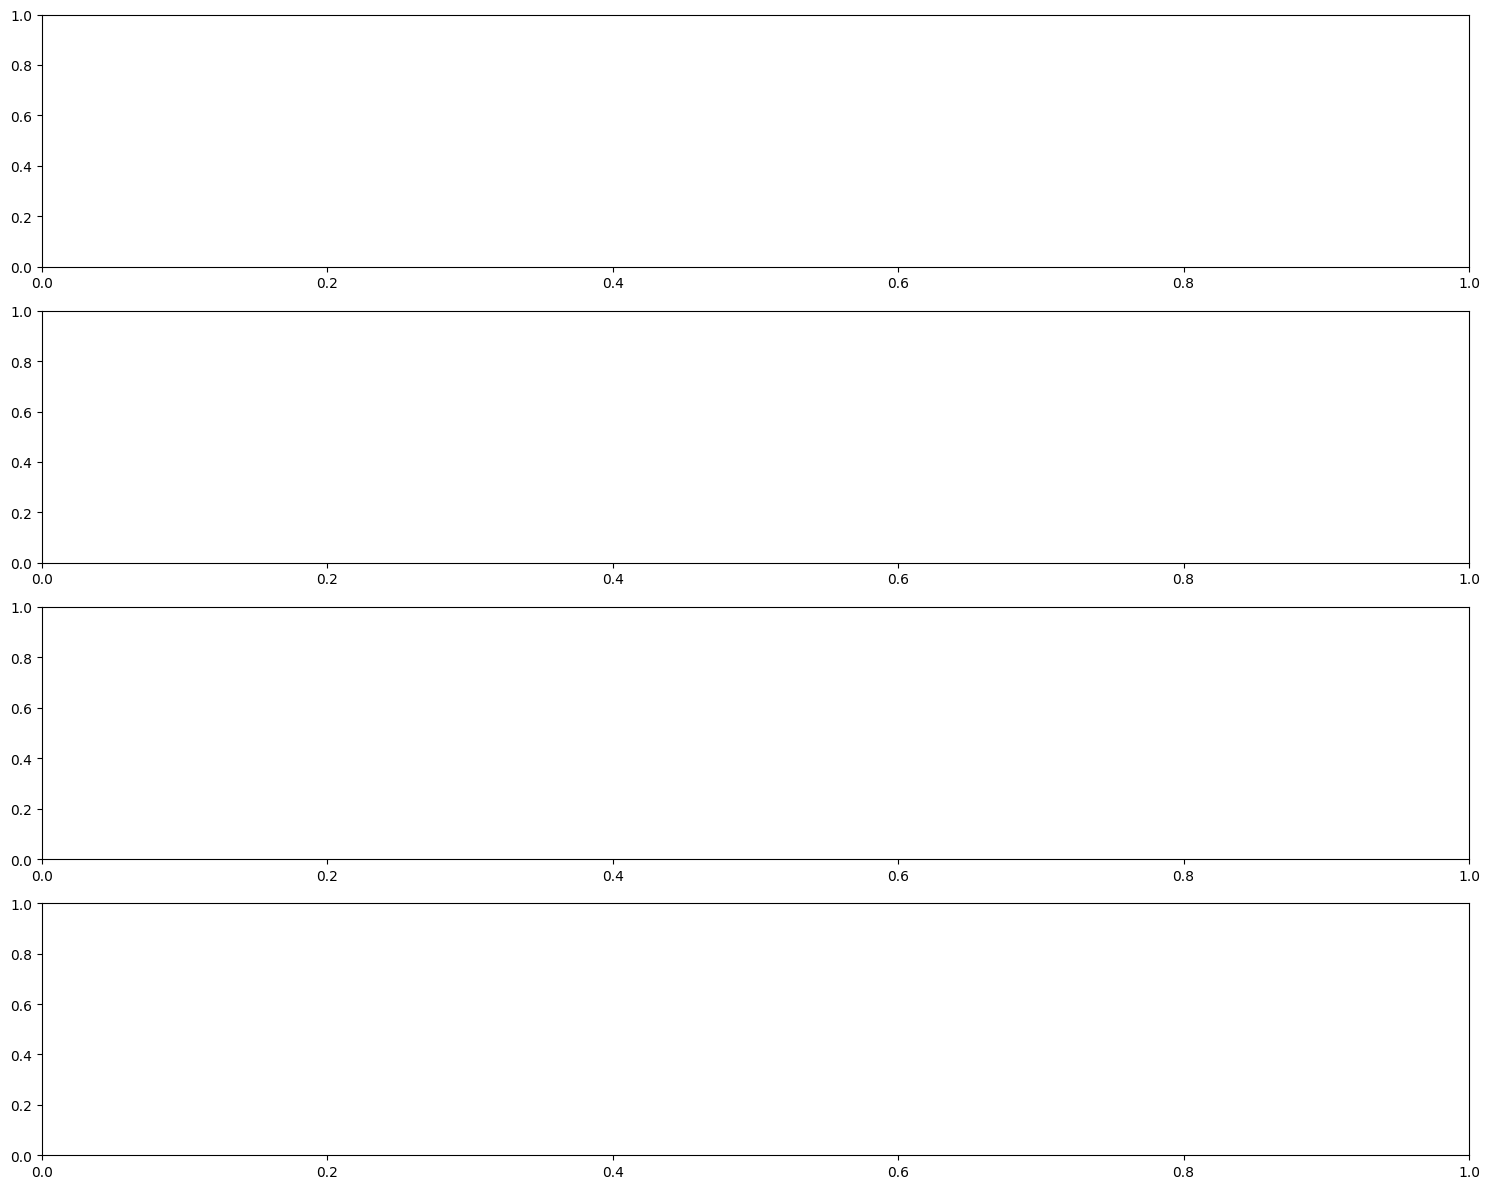

In [50]:
rows, cols = len(sample_rmse_dfs), 1
bar_fig, bar_axs = plt.subplots(rows, cols, figsize=(15*cols, 3*rows))
box_fig, box_axs = plt.subplots(rows, cols, figsize=(15*cols, 3*rows))
print('Plotting...')
for row, thresh in enumerate(sample_rmse_dfs.keys()):
    print(thresh)
    ax = bar_axs[row]
    df = dataset_mae_dfs[thresh].copy()
    df['method'] = df['method'].map(method_label_map)
    df['dataset'] = df['dataset'].map(dataset_label_map)
    sns.barplot(df, y='metric', x='dataset', hue='method', ax=ax, hue_order=method_order)
    ax.set_ylabel('MAE')
    ticks = [k.get_text() for k  in ax.get_xticklabels()]
    ax.set_xticks(ax.get_xticks()) # Workaround to silence a warning
    ax.set_xticklabels(ticks, rotation=45, ha='right')
    ax.set_title('thresh')
    if row == 0:
        ax.legend(loc='upper center', bbox_to_anchor=(0.50, 1.0), ncol=5)
    else:
        ax.legend().remove()



                       
#bar_all_fig.savefig('figures/mae_bar_all.pdf', bbox_inches='tight')
bar_fig.tight_layout()
#bar_fig.savefig('figures/mae_bar.pdf', bbox_inches='tight')
box_fig.tight_layout()
#box_fig.savefig('figures/sample_rmse_box.pdf', bbox_inches='tight')

## Ablation Study

In [11]:
ablation_rmse_dfs = []
ablation_mae_dfs = []
with tqdm(total=len(ablation_datasets)) as pbar:
    for ds_name, ds in ablation_datasets.items():
        gt_column = 'abundance_gt'
        ids = ds.values['peptide'][gt_column]
        ids = ids[~ids.isna() & ds.values['peptide']['abundance'].isna()].index
        #ids = ids[ids.get_level_values('id').isin(not_all_missing)]
        metric_df = compare_columns(dataset=ds, molecule='peptide', columns=eval_columns, comparison_column=gt_column,
                                    metric='RMSE', logarithmize=False, ids=ids, per_sample=True, ignore_missing=False)
        metric_df['dataset'] = ds_name
        ablation_rmse_dfs.append(metric_df)

        df = ds.values['peptide'].df
        df = df.loc[ids]
        ae = ((df - df[[gt_column]].values).abs())
        ae = ae[eval_columns]
        mae = ae.mean()
        mae_df = pd.DataFrame({'metric':mae})
        mae_df.index.set_names('column', inplace=True)
        mae_df = mae_df.reset_index()
        mae_df['dataset'] = ds_name
        ablation_mae_dfs.append(mae_df)
        pbar.update(1)
ablation_rmse_dfs= pd.concat(ablation_rmse_dfs)
ablation_mae_dfs = pd.concat(ablation_mae_dfs)

  0%|          | 0/5 [00:00<?, ?it/s]

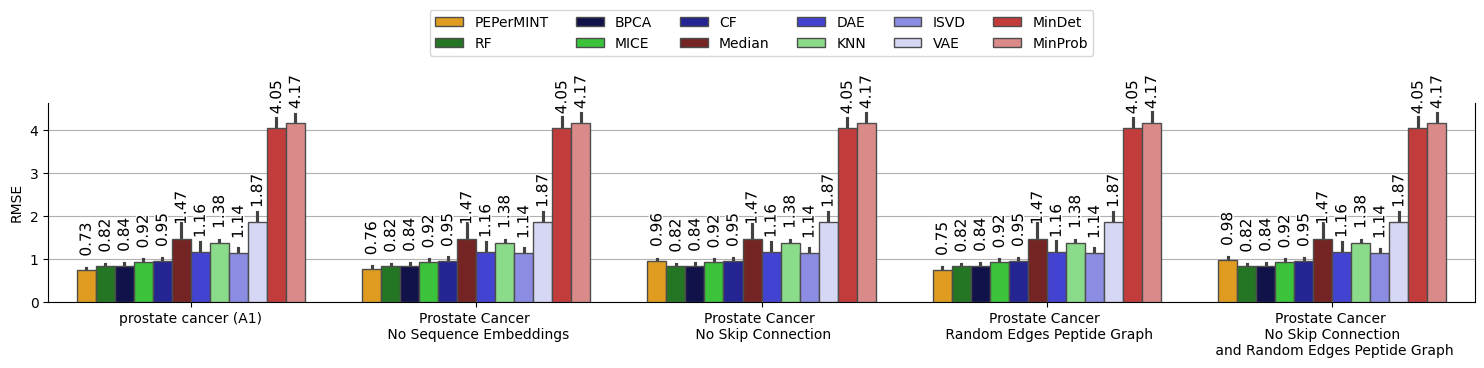

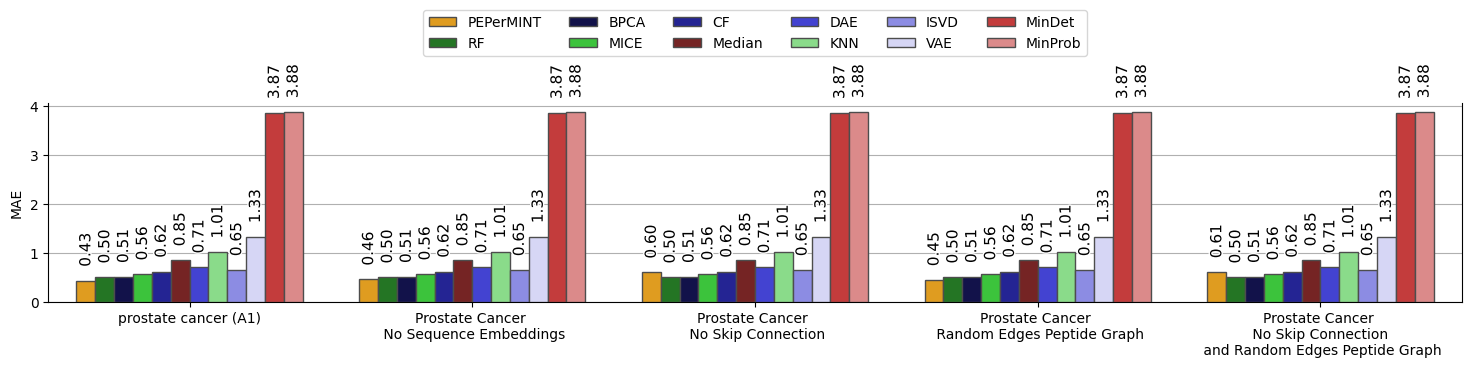

In [28]:
import matplotlib.patheffects as PathEffects

for df, ylabel, fig_name in [(ablation_rmse_dfs.copy(), 'RMSE', 'sample_wise_rmse_bar'), (ablation_mae_dfs.copy(), 'MAE', 'dataset_mae_bar')]:
   fig, ax = plt.subplots(1, 1, figsize=(15, 4))
   df['column'] = df['column'].map(method_label_map)
   df['dataset'] = df['dataset'].map(dataset_label_map)
   sns.barplot(df, y='metric', x='dataset', hue='column', ax=ax, hue_order=method_order,  linewidth=1.0, edgecolor="0.3", palette=PALETTE,
               order=[dataset_label_map[d] for d in ablation_datasets.keys()],
               zorder=3)
   ax.set_ylabel(ylabel)
   ax.grid(axis='y', zorder=0)
   ax.spines['top'].set_visible(False)
   for container in ax.containers:
      ax.bar_label(container, fmt='%.2f', label_type='edge', rotation = 90, padding=10, fontsize=11, path_effects=[PathEffects.withStroke(linewidth=2, foreground='w')])#15.1)
   ticks = [k.get_text() for k  in ax.get_xticklabels()]
   ax.set_xticks(ax.get_xticks()) # Workaround to silence a warning
   ax.set_xticklabels(ticks, ha='center')
   ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.2), ncol=6, fontsize=10)
   ax.set_xlabel('')
   #ax.set_ylim(0, 5.0)
   fig.tight_layout()
   fig.savefig(f'figures/ablation_{fig_name}.pdf')

Plotting...


  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_2244615/1442332767.py:58: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  bar_fig.tight_layout()
/tmp/ipykernel_2244615/1442332767.py:60: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  box_fig.tight_layout()


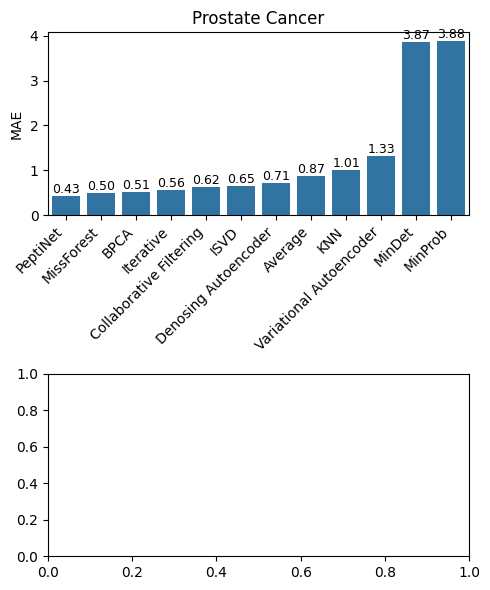

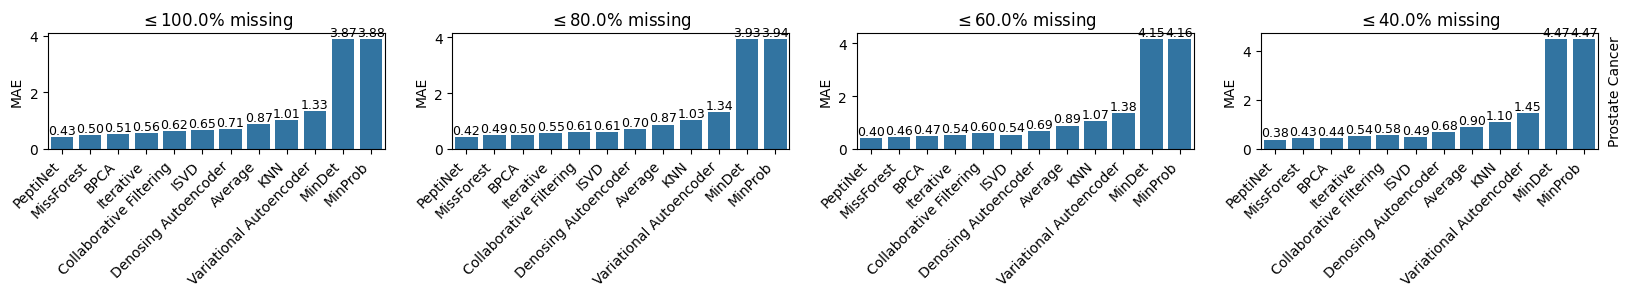

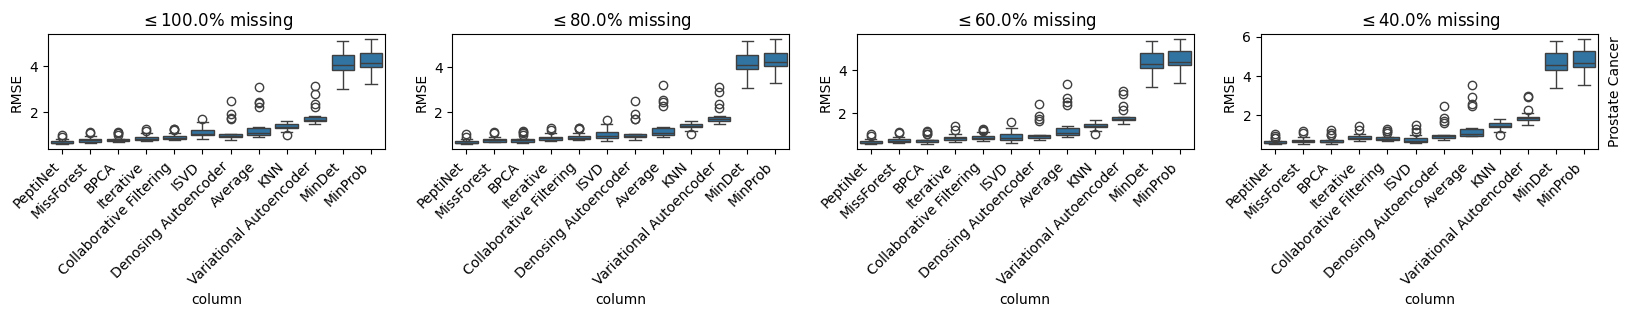

In [6]:
ranks = pd.Series(0, index=list(dataset_ae_results.values())[0][1.0].index)
for ds_name, metric in dataset_ae_results.items():
    metric = metric[1.0]
    ranks += metric.rank()
method_order = list(ranks.sort_values().index)

bar_all_fig, bar_all_axs = plt.subplots(2, math.ceil(rows / 2), figsize=(5*math.ceil(rows/2), 6), squeeze=False)
bar_all_axs = bar_all_axs.flatten()
bar_fig, bar_axs = plt.subplots(rows, cols, figsize=(5*cols, 1.5*rows), squeeze=False)
box_fig, box_axs = plt.subplots(rows, cols, figsize=(5*cols, 1.5*rows), squeeze=False)
print('Plotting...')
with tqdm(total=rows*cols) as pbar:
    for row, ds_name in enumerate(imp_datasets.keys()):
        if ds_name not in EVAL_DATASETS:
            continue
        ax = bar_all_axs[row]
        sns.barplot(dataset_ae_results[ds_name][1.0], ax=ax, order=method_order)
        ax.bar_label(ax.containers[0], fontsize=9, fmt='%.2f')
        ax.set_ylabel('MAE')
        ax.set_title(dataset_label_map[ds_name])
        ticks = [method_label_map[k.get_text()] for k  in ax.get_xticklabels()]
        ax.set_xticks(ax.get_xticks()) # Workaround to silence a warning
        ax.set_xticklabels(ticks, rotation=45, ha='right')
        for col, thresh in enumerate(thresholds):
            ax = box_axs[row, col]
            sns.boxplot(data=sample_rmse_results[ds_name][thresh], x='column', y='metric', ax=ax, order=method_order)
            ax.set_ylabel('RMSE')
            ax = bar_axs[row, col]
            sns.barplot(dataset_ae_results[ds_name][thresh], ax=ax, order=method_order)
            ax.bar_label(ax.containers[0], fontsize=9, fmt='%.2f')
            ax.set_ylabel('MAE')
            for axs in [bar_axs, box_axs]:
                ax = axs[row, col]
                if row == 0:
                    ax.set_title(f'$\leq${thresh * 100}% missing')
                if row == axs.shape[0] - 1:
                    ticks = [method_label_map[k.get_text()] for k  in ax.get_xticklabels()]
                    ax.set_xticks(ax.get_xticks()) # Workaround to silence a warning
                    ax.set_xticklabels(ticks, rotation=45, ha='right')
                else:
                    ax.get_xaxis().set_visible(False)
                if col == axs.shape[1] - 1:
                    ax.text(
                        s=dataset_label_map[ds_name],
                        rotation=90,
                        x=1.05,
                        y=0.5,
                        ha="center",
                        va="center",
                        transform=ax.transAxes,
                        fontsize=10,
                    )
            #print(((df - df[[gt_column]].values)**2).mean())
            #fig, ax = plt.subplots(1, 1, figsize=(5, 5))
            #paired_wilcoxon_matrix(dataset=ds, molecule='peptide', eval_columns=eval_columns, gt_column=gt_column, ax=ax, ids=ids)
            #ax.set_title('Pairwise Significance Test (Wilcoxon Signed-Rank Test)')
            pbar.update(1)
bar_all_fig.tight_layout()
#bar_all_fig.savefig('figures/mae_bar_all.pdf', bbox_inches='tight')
bar_fig.tight_layout()
#bar_fig.savefig('figures/mae_bar.pdf', bbox_inches='tight')
box_fig.tight_layout()
#box_fig.savefig('figures/sample_rmse_box.pdf', bbox_inches='tight')

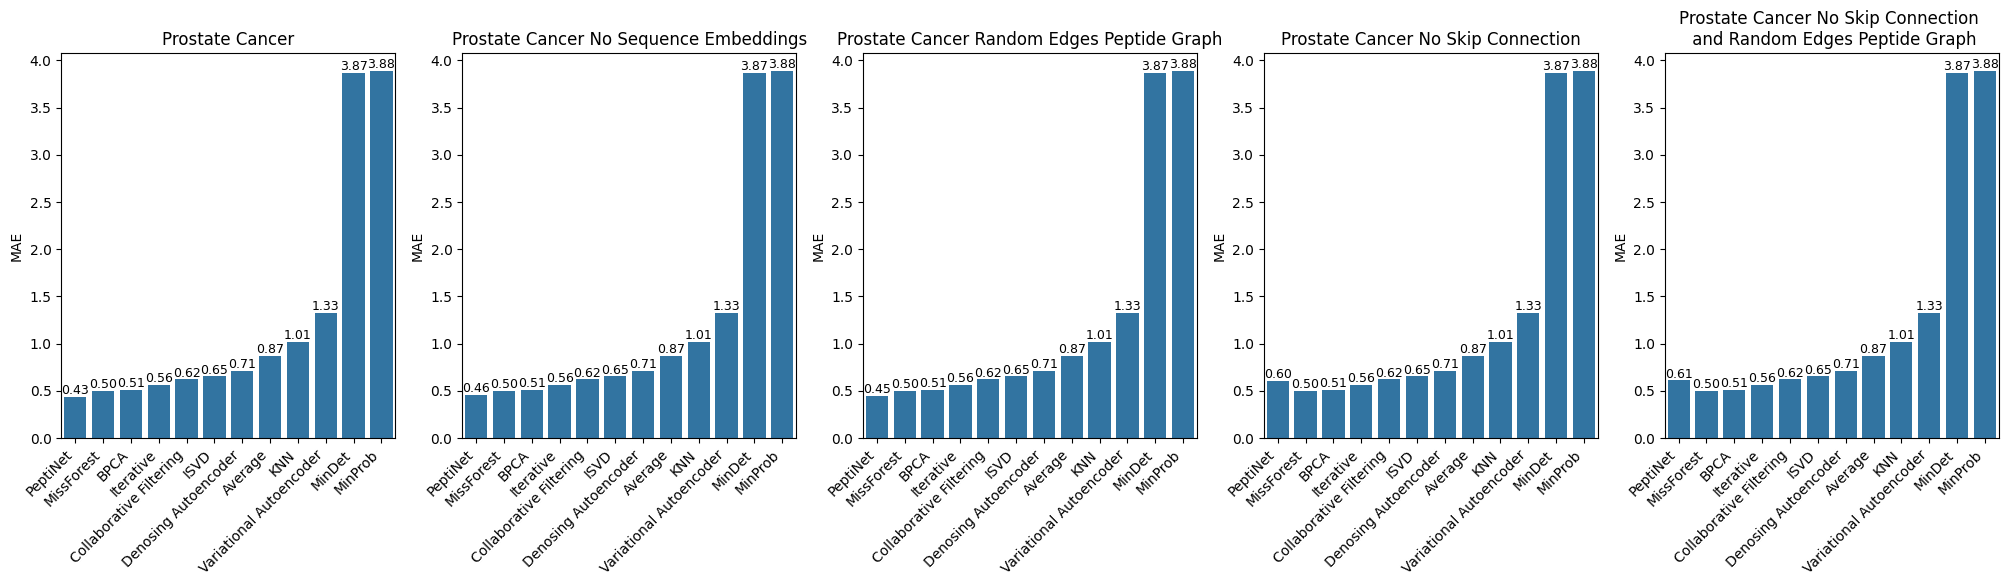

In [40]:
#Ablation study
from utils.globals import method_label_map, dataset_label_map

fig, axs = plt.subplots(1,5, figsize=(25, 5))
for ax, ds_name in zip(axs, ['prostate_cancer', 'prostate_cancer_zero_sequence_embeddings', 'prostate_cancer_random_edges',
                              'prostate_cancer_no_skip', 'prostate_cancer_no_skip_random_edges']):
    sns.barplot(dataset_ae_results[ds_name][1.0], ax=ax, order=method_order)
    ax.bar_label(ax.containers[0], fontsize=9, fmt='%.2f')
    ax.set_ylabel('MAE')
    ax.set_title(dataset_label_map[ds_name])
    ticks = [method_label_map[k.get_text()] for k  in ax.get_xticklabels()]
    ax.set_xticks(ax.get_xticks()) # Workaround to silence a warning
    ax.set_xticklabels(ticks, rotation=45, ha='right')

## Wilcoxon Matrix

In [7]:
#Generate the Wilcoxon signed-rank test matrices
intervals = [(1.0, 0.0), (1.0, 0.75), (0.75, 0.5), (0.5, 0.25), (0.25, 0.0)]
wilcoxon_results = {}

with tqdm(total=len(imp_datasets) * len(intervals)) as pbar:
    for ds_name, ds in imp_datasets.items():
        wilcoxon_results[ds_name] = {}
        for inter in intervals:
            gt_column = 'abundance_gt'
            ids = ds.values['peptide']['abundance_gt']
            ids = ids[~ids.isna() & ds.values['peptide']['abundance'].isna()].index
            missingness = ds.get_wf('peptide', 'abundance')
            missingness = missingness[(missingness.isna().sum(axis=1) / missingness.shape[1] <= inter[0]) & 
                                      (missingness.isna().sum(axis=1) / missingness.shape[1] >= inter[1])].index
            ids = ids[ids.get_level_values('id').isin(missingness)]
            mat = paired_wilcoxon_matrix(dataset=ds, molecule='peptide', eval_columns=eval_columns, gt_column=gt_column, ax=None, ids=ids)
            wilcoxon_results[ds_name][inter] = mat
            pbar.update(1)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

[11  8 10  7  8  6  5  2  4  3  0  0]
breast_cancer
[11 10  9  8  6  4  5  3  7  2  1  0]
prostate_cancer
[11  9  9  8  7  5  4  3  5  2  0  0]
crohns_fibrosis
[11  8  8  8  7  5  4  3  6  2  0  0]
maxlfqbench
[11  9  3  5  2  5  1  3  3  0  9  4]
blood_ddia
[ 8  7 10  9  6  9  4  5  2  3  1  0]
human_ecoli_ddia


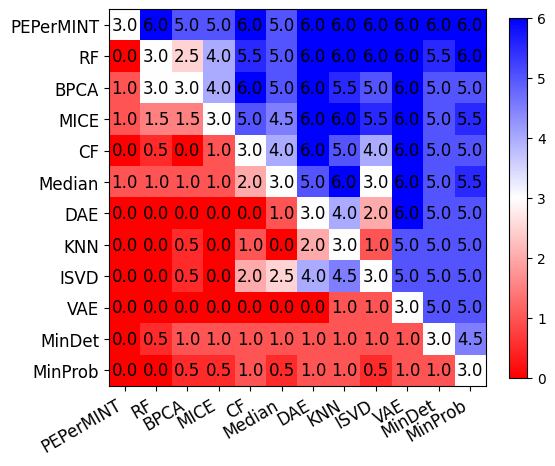

In [99]:
res_mats = {}
res_mat = np.zeros_like(list(wilcoxon_results.values())[0][(1.0, 0.0)][0], dtype=float)

significance_level = 0.05
for ds_name, measure in wilcoxon_results.items():
    if ds_name not in EVAL_DATASETS:
        continue
    results_less, results_greater = measure[(1.0, 0.0)]
    results_less.rename(columns=method_label_map, index=method_label_map, inplace=True)
    results_greater.rename(columns=method_label_map, index=method_label_map, inplace=True)
    results_less = results_less.loc[method_order, method_order]
    results_greater = results_greater.loc[method_order, method_order]
    vec_fun = np.vectorize(lambda x: x.pvalue if x is not None else 0.5)
    pvalues_less = vec_fun(results_less)
    pvalues_greater = vec_fun(results_greater)
    sl = significance_level
    sl = sl / (len(eval_columns)**2 - len(eval_columns))
    res_mat[pvalues_less < sl] += 1
    print((pvalues_less < sl).sum(axis=1))
    res_mat[(pvalues_less >= sl) & (pvalues_greater >= 0.05)] += 0.5
    print(ds_name)
    #res_mat[pvalues_greater < 0.05] += 1
fig, ax = plt.subplots(1,1, figsize=(6, 6))
mappable = ax.matshow(res_mat, cmap=matplotlib.cm.bwr.reversed())
ax.set_xticks(range(len(method_order)))
ax.set_xticklabels([m for m in method_order], rotation=30, ha='right', fontsize=12)
ax.xaxis.set_ticks_position('bottom')
ax.set_yticks(range(len(method_order)))
ax.set_yticklabels([m for m in method_order], rotation=0, fontsize=12)
for (i, j), z in np.ndenumerate(res_mat):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', fontsize=12)
ax.grid(False)
#ax.set_title(f'$\leq${thresh * 100}% missing')
fig.colorbar(mappable, shrink=0.66)
fig.tight_layout()
fig.savefig('figures/wilcoxon_matrix.pdf', bbox_inches='tight')

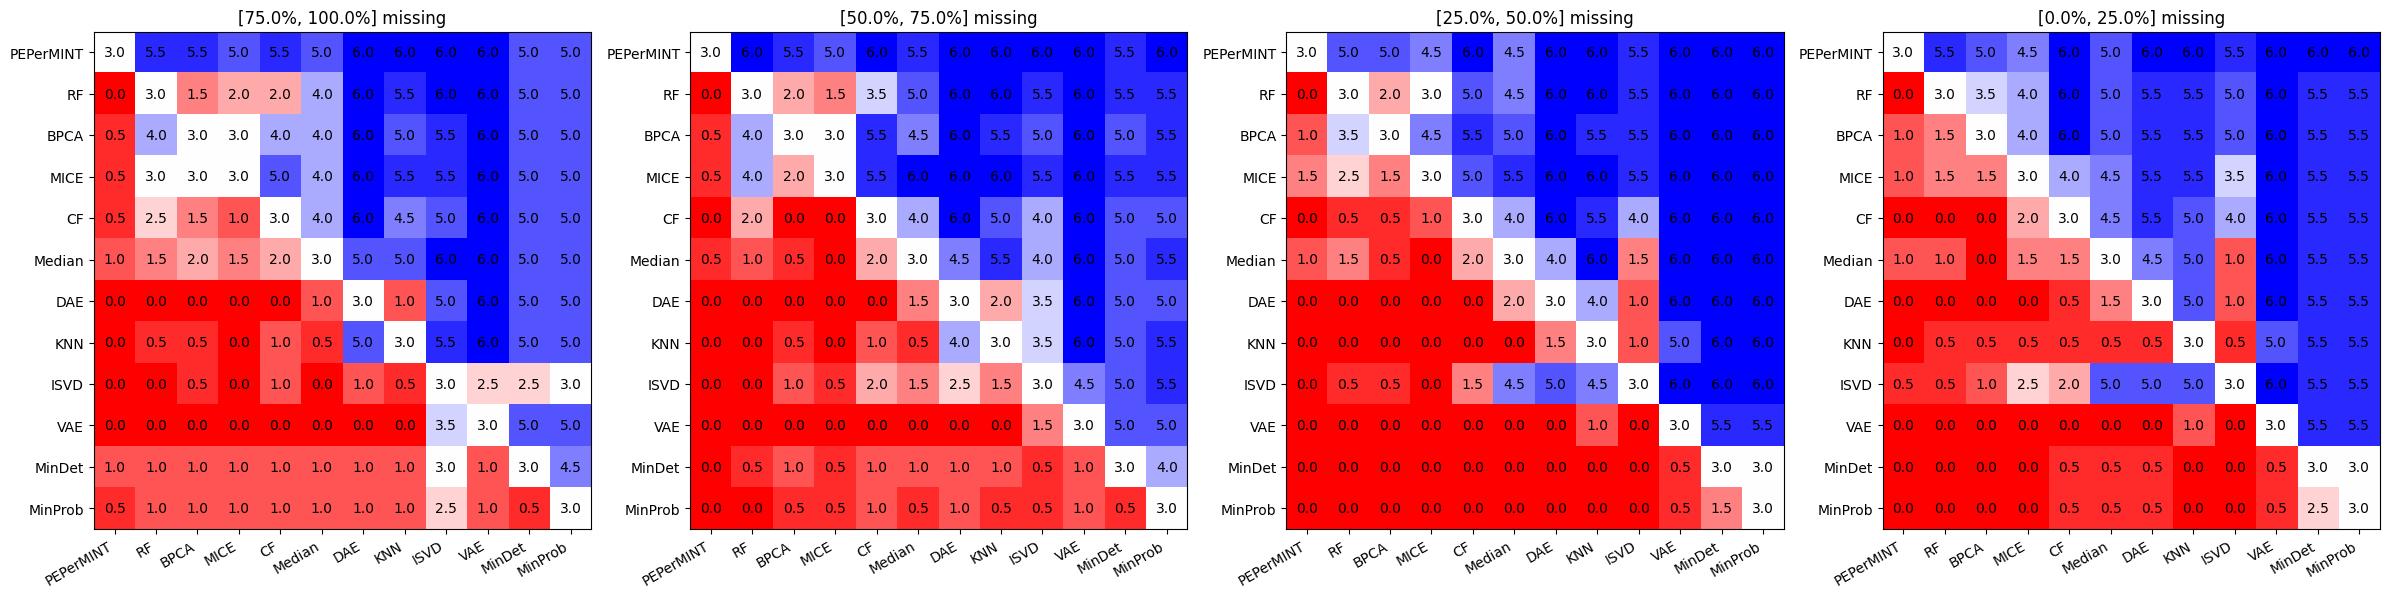

In [8]:
res_mats = {}
for thresh, measures in list(wilcoxon_results.values())[0].items():
    if thresh == (1.0, 0.0):
        continue
    res_mats[thresh] = np.zeros_like(measures[0], dtype=float)

significance_level = 0.05
for ds_name, measures in wilcoxon_results.items():
    if ds_name not in EVAL_DATASETS:
        continue
    for thresh, measure in measures.items():
        if thresh == (1.0, 0.0):
            continue
        results_less, results_greater = measure
        results_less.rename(columns=method_label_map, index=method_label_map, inplace=True)
        results_greater.rename(columns=method_label_map, index=method_label_map, inplace=True)
        results_less = results_less.loc[method_order, method_order]
        results_greater = results_greater.loc[method_order, method_order]
        vec_fun = np.vectorize(lambda x: x.pvalue if x is not None else 0.5)
        pvalues_less = vec_fun(results_less)
        pvalues_greater = vec_fun(results_greater)
        sl = significance_level
        sl = sl / (len(eval_columns)**2 - len(eval_columns))
        res_mats[thresh][pvalues_less < sl] += 1
        res_mats[thresh][(pvalues_less >= sl) & (pvalues_greater >= 0.05)] += 0.5
        #res_mat[pvalues_greater < 0.05] += 1
cols = len(res_mats)
fig, axs = plt.subplots(1,cols, figsize=(cols * 6, 6))
for ax, (thresh, res_mat) in zip(axs, res_mats.items()):
    ax.matshow(res_mat, cmap=matplotlib.cm.bwr.reversed())
    ax.set_xticks(range(len(method_order)))
    ax.set_xticklabels([m for m in method_order], rotation=30, ha='right')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_yticks(range(len(method_order)))
    ax.set_yticklabels([m for m in method_order], rotation=0)
    for (i, j), z in np.ndenumerate(res_mat):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    ax.grid(False)
    ax.set_title(f'[{thresh[1] * 100}%, {thresh[0] * 100}%] missing')
fig.tight_layout()
fig.savefig('figures/wilcoxon_matrix_stratified.pdf', bbox_inches='tight')

## Scatter Plots

gnn_imp
0.6367403190030742
0.4137797367640254
SpearmanrResult(correlation=0.8770040639393645, pvalue=0.0)
median
0.6482204794685353
0.4094059708786214
SpearmanrResult(correlation=0.8661699776896556, pvalue=0.0)
bpca
0.6456091487758046
0.4081236765767555
SpearmanrResult(correlation=0.8676431930082562, pvalue=0.0)
iterative
0.6485113850617427
0.411796902508479
SpearmanrResult(correlation=0.8686646033851797, pvalue=0.0)


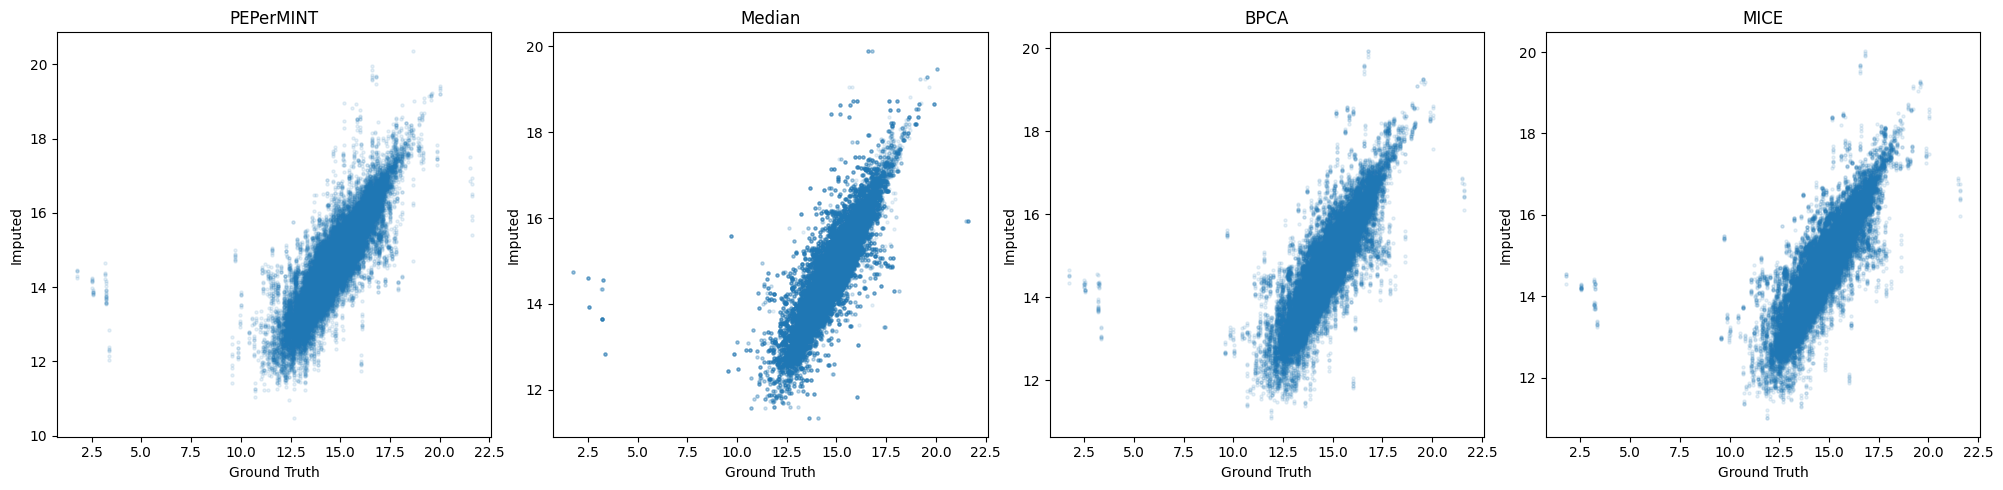

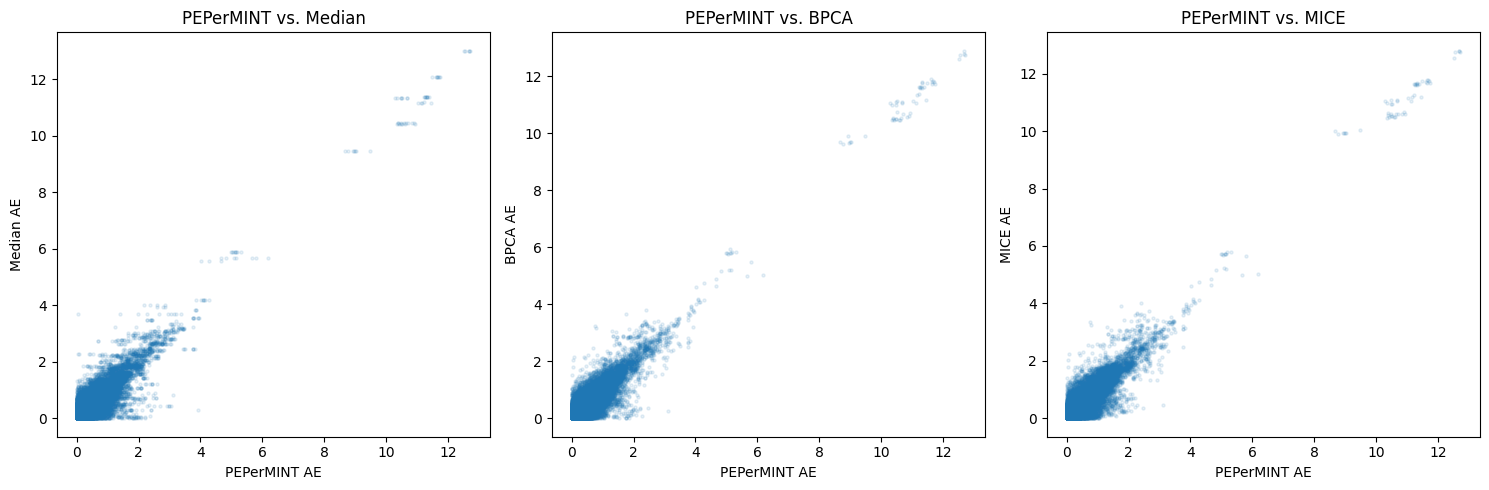

In [102]:
from mpl_scatter_density import ScatterDensityArtist
from scipy.stats import pearsonr, spearmanr

ds = imp_datasets['human_ecoli_ddia']

methods = ['gnn_imp', 'median', 'bpca', 'iterative']
ids = ds.values['peptide']['abundance_gt']
#ids = ids[ids > 12.0]
#ids = ids[ids<19]
ids = ids[(~ids.isna()) & (ds.values['peptide']['abundance'].isna())].index

fig, axs = plt.subplots(1, len(methods), figsize=(len(methods) * 5, 5))
for m, ax in zip(methods, axs):
    print(m)
    df = ds.values['peptide'].df[['abundance_gt', m]]
    df = df.loc[ids]
    print(np.sqrt(((df.abundance_gt-df[m])**2).mean()))
    print((df.abundance_gt-df[m]).abs().mean())
    #xy = np.vstack([gt,imp])
    #z = gaussian_kde(xy)(xy)
    #a = ScatterDensityArtist(ax, gt, imp, dpi=100)
    #ax.add_artist(a)
    print(spearmanr(df.abundance_gt, df[m]))
    ax.scatter(df.abundance_gt, df[m], s=5, alpha=0.1)
    ax.set_xlabel('Ground Truth')
    ax.set_ylabel('Imputed')
    #ax.set_ylim(imp.min(), imp.max())
    #ax.set_xlim(gt.min(), gt.max())
    ax.set_title(method_label_map[m])
fig.tight_layout()
fig.savefig('figures/human_ecoli_selected_abundance_scatter.png', bbox_inches='tight')

fig, axs = plt.subplots(1, (len(methods)-1), figsize=((len(methods)-1) * 5, 5))
for m1 in ['gnn_imp']:
    for m2, ax in zip(['median', 'bpca', 'iterative'], axs):
        df = ds.values['peptide'].df[['abundance_gt', m1, m2]]
        df = df.loc[ids]
        #ax.scatter(df['abundance_gt'].values, df[m1].values, s=5, alpha=0.1)
        ax.scatter((df[m1]-df['abundance_gt']).abs(), (df[m2]-df['abundance_gt']).abs(), s=5, alpha=0.1)
        ax.set_xlabel(f'{method_label_map[m1]} AE')
        ax.set_ylabel(f'{method_label_map[m2]} AE')
        #ax.set_ylim(imp.min(), imp.max())
        #ax.set_xlim(gt.min(), gt.max())
        ax.set_title(f'{method_label_map[m1]} vs. {method_label_map[m2]}')
fig.tight_layout()
fig.savefig('figures/human_ecoli_selected_ae_scatter.png', bbox_inches='tight')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 655.5/655.5 kB 8.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 3.3 MB/s eta 0:00:00


## Uncertainty

/tmp/ipykernel_31508/164473409.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_31508/164473409.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


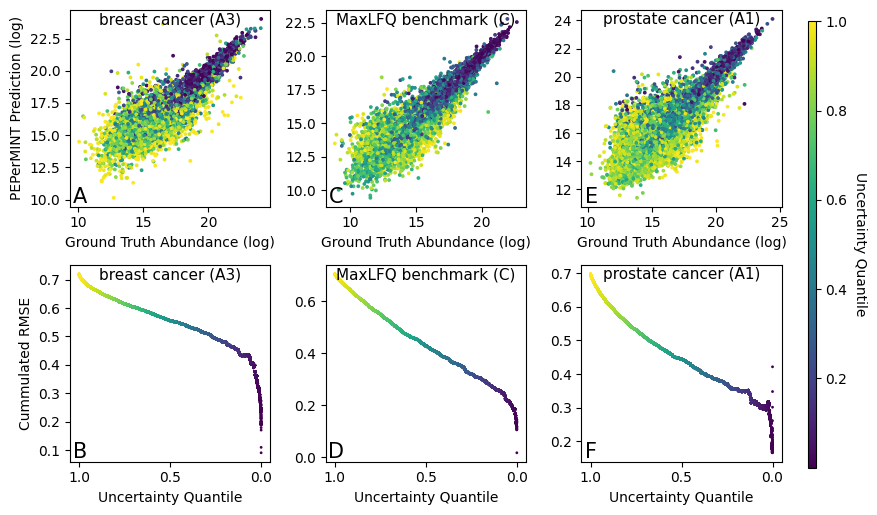

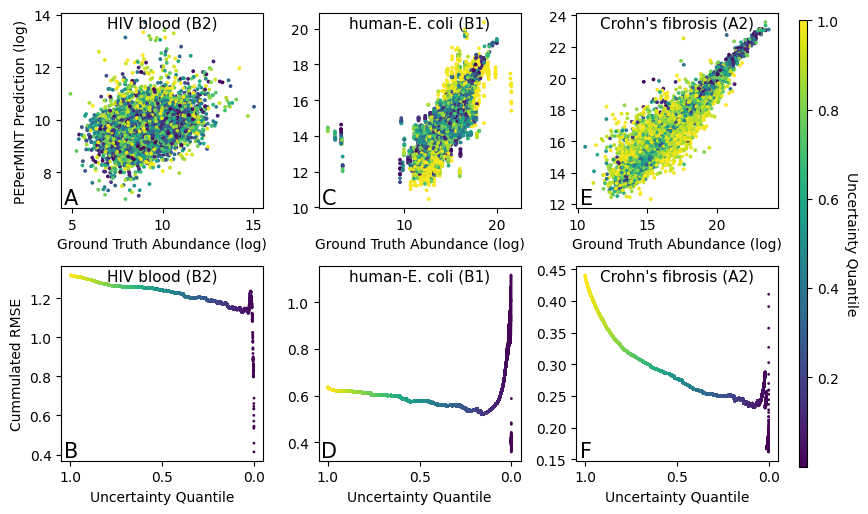

In [19]:
import pandas as pd
from matplotlib import pyplot as plt

main_uncertainty_datasets = ['breast_cancer', 'maxlfqbench', 'prostate_cancer', ]
supplementary_uncertainty_datasets = ['blood_ddia', 'human_ecoli_ddia', 'crohns_fibrosis']
letters = ['A', 'B', 'C', 'D', 'E', 'F']
for ds_names, label in [(main_uncertainty_datasets, 'main'), (supplementary_uncertainty_datasets, 'supplementary')]:
    fig, axs = plt.subplots(2, len(ds_names), figsize=(8, 5.25))
    axs = axs.transpose().flatten()
    for i, ds_name in enumerate(ds_names):
        ds = imp_datasets[ds_name]
        df = ds.values['peptide'].df
        gt_column = 'abundance_gt'
        gt =df[gt_column]
        mask = df['abundance'].isna() &  ~gt.isna()
        gt = gt[mask]
        gnn = df[f'gnn_imp']
        gnn = gnn[mask]
        uncertainty = df[f'gnn_imp_var']
        uncertainty = uncertainty[mask]
        diff = (gt - gnn).abs()
        se  = (gt - gnn)**2
        df = pd.DataFrame({'gt':gt, 'gnn':gnn, 'ae':diff, 'se':se, 'uncertainty':uncertainty})
        df['ae_rank'] = df.ae.rank()
        df['uncertainty_rank'] = df.uncertainty.rank() / df.shape[0]
        ax = axs[2 * i]
        mappable = ax.scatter(gt, gnn, c=df.uncertainty_rank, s=3)
        ax.text(0.05, 0.05, letters[2 * i], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=15)
        #mappable = ax.scatter(np.abs(gt-gnn), np.log(uncertainty), s=5)
        #ax.set_title(f'{ds_name_map[ds_name]}, {agg} aggregation')
        ax.set_xlabel('Ground Truth Abundance (log)')
        ax.set_title(f'{dataset_label_map[ds_name]}', x=0.5, y=0.885, fontsize=11)
        if i == 0:
            ax.set_ylabel('PEPerMINT Prediction (log)')
        ax = axs[2 * i + 1]
        ax.text(0.05, 0.05, letters[2 * i + 1], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=15)
        df = df.sort_values('uncertainty', ascending=True)
        df['mae'] = df['ae'].cumsum() / np.arange(1, df.shape[0] + 1)
        df['mse'] = df['se'].cumsum() / np.arange(1, df.shape[0] + 1)
        df['rmse'] = np.sqrt(df['mse'])
        ax.scatter(df.uncertainty_rank, df['rmse'], s=1, c=df.uncertainty_rank)
        ax.set_xlim(ax.get_xlim()[::-1])
        #ax.scatter(df['ae'], np.log(df['uncertainty']), s=1)
        ax.set_xlabel('Uncertainty Quantile')
        ax.set_title(f'{dataset_label_map[ds_name]}', x=0.5, y=0.885, fontsize=11)
        if i == 0:
            ax.set_ylabel('Cummulated RMSE')

        # ax = axs[3 * i + 2]
        # ax.scatter(df.uncertainty_rank, df['ae'], s=1)
        # ax.set_xlabel('Uncertainty Quantile')
        # ax.set_ylabel('AE')
        # ax.set_xlabel('Uncertainty Quantile')
    #cbar = fig.colorbar(mappable=mappable)
    #cbar.set_label('Uncertainty Quantile', rotation=-90, verticalalignment='bottom')
    fig.subplots_adjust(right=0.95)
    cbar_ax = fig.add_axes([1.005, 0.1, 0.01, 0.85])
    cbar = fig.colorbar(mappable=mappable, cax=cbar_ax)
    cbar.set_label('Uncertainty Quantile', rotation=-90, verticalalignment='bottom')
    fig.tight_layout()
    fig.savefig(f'figures/uncertainty_{label}.png', bbox_inches='tight')

## Differential Expressions

In [4]:
from typing import Optional, List
from pyproteonet.metrics.differential_expression import find_des, evaluate_des
from pyproteonet.visualization.differential_expression import plot_des_volcano
import math
numerator_samples = ['H1','H2','H3']
denominator_samples = ['L1','L2','L3']
fc_thresh = 1.5

from typing import Optional
def plot_eval_des(ds, molecule, columns, ref_column, numerator_samples, denominator_samples, save_dir=None, separate_figs: bool = False, 
                  groups: Optional[List[str]] = None, ylim=None):
    if not separate_figs:
        fig, axs = plt.subplots(2, 1, figsize=(12, 16))
        i=0
    if groups is not None:
        assert len(groups) == len(columns)
    if separate_figs:
        fig, axs = plt.subplots(1, 1, figsize=(20, 8))
        axs = [axs]
        i=0
    is_ecoli = ds.molecules[molecule].is_ecoli
    categories = pd.Series(index=is_ecoli.index, data='')
    categories.loc[is_ecoli] = 'E. coli'
    categories.loc[~is_ecoli] = 'Human'
    gt_fc = pd.Series(index=categories.index, data=1)
    gt_fc.loc[categories == 'E. coli'] = 3
    de_res = []
    res = evaluate_des(dataset=ds, molecule=molecule, columns=columns + [ref_column], numerator_samples=numerator_samples,
                       denominator_samples=denominator_samples, gt_fc=gt_fc,
                       min_fc=fc_thresh, max_pvalue=0.05, is_log=True, absolute_metrics=False)
    res['Method'] = res.index
    res['run'] = 0
    res.loc[:, ['Recall', 'Precision', 'Specificity', 'Accuracy', 'FP Rate', 'F1 Score']] = (res[['Recall', 'Precision', 'Specificity', 'Accuracy', 'FP Rate', 'F1 Score']] - res.loc[ref_column])
    de_res.append(res)
    de_res = pd.concat(de_res, ignore_index=True)
    #de_res.loc[:, ['Correct DE', 'Correct no DE', 'Correctly Classified', 'False Positives']] = (de_res[['Correct DE', 'Correct no DE', 'Correctly Classified', 'False Positives']] - de_res.loc['aggregated'])
    de_res.rename(columns={'F1 Score': 'F₁ Score'}, inplace=True)
    de_res = de_res.melt(id_vars=['Method'], value_vars=['Recall', 'Precision', 'Specificity', 'Accuracy', 'FP Rate', 'F₁ Score'], value_name='%', var_name='Metric')
    if groups is not None:
        groups_map = {c:g for c,g in zip(columns, groups)}
        de_res['Metric'] = de_res['Metric'] + ' ' + de_res['Method'].map(groups_map)
    #de_res['Method'] = de_res['Method'].map(column_label_map)
    #de_res = de_res.melt(id_vars=['Method'], value_vars=['Correct DE', 'Correct no DE', 'Correctly Classified', 'False Positives'], value_name='%', var_name='Metric')
    ax = axs[i]
    sns.barplot(data=de_res, x='Method', y='%', hue='Metric', ax=ax)
    for con in ax.containers:
        ax.bar_label(con, fmt='%.3f')
    if i==0:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, fancybox=True, shadow=True)
    else:
        ax.legend().remove()
    i+=1
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('')
    fig.tight_layout()
    return de_res

/tmp/ipykernel_31508/2901959704.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45, ha='right')


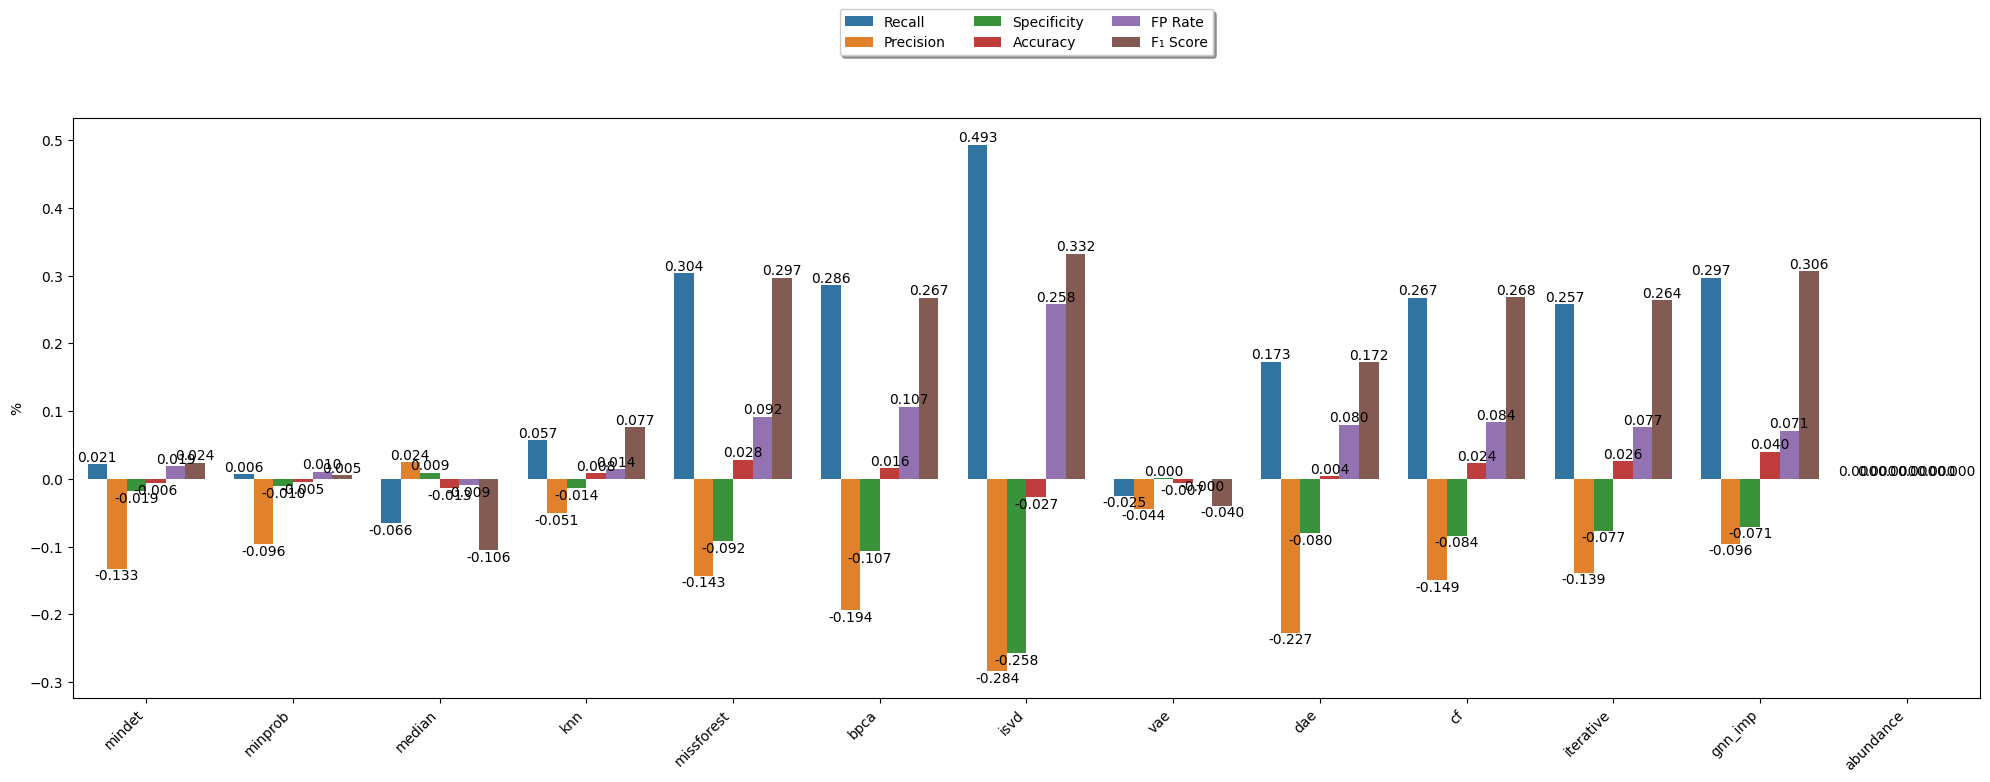

In [5]:
import seaborn as sns
de_res = plot_eval_des(ds=imp_datasets['maxlfqbench'], molecule='peptide', columns=eval_columns, ref_column='abundance',
                       numerator_samples=numerator_samples, denominator_samples=denominator_samples, save_dir=None, separate_figs=True, ylim=(-0.6, 0.4))

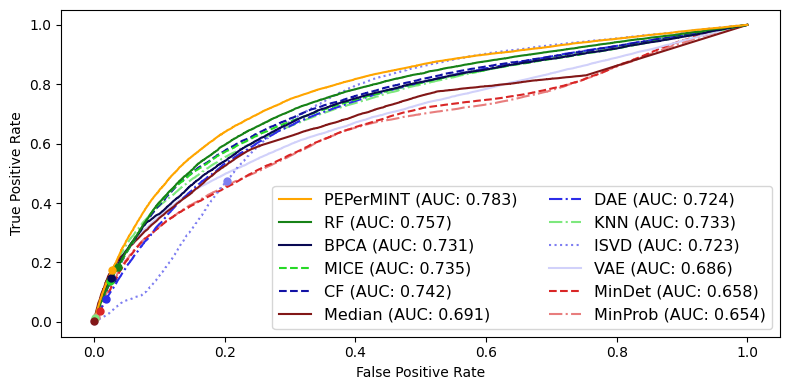

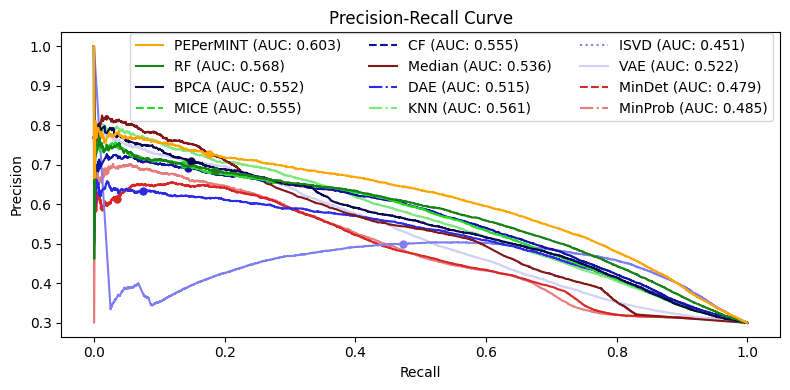

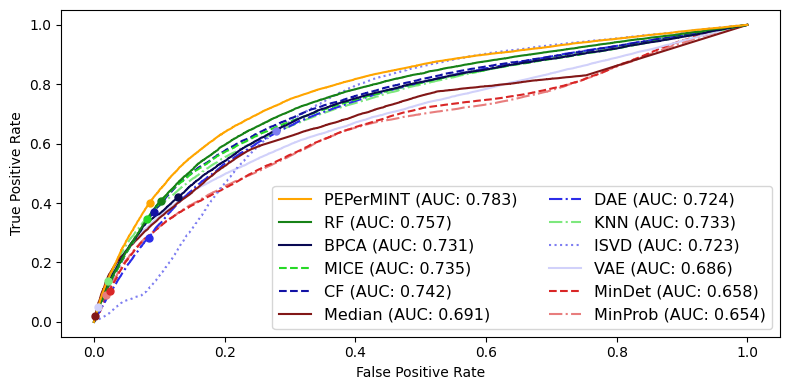

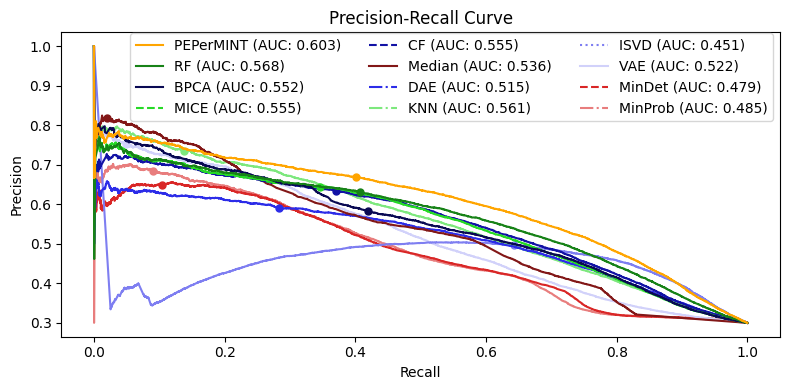

In [52]:
from matplotlib import cm

ds = imp_datasets['maxlfqbench']

numerator_samples = ['H1','H2','H3']
denominator_samples = ['L1','L2','L3']
fc_thresh = 1.5

mols = ds.molecules['peptide']
ids = mols.loc[(mols.is_ecoli.astype(int) + mols.is_human.astype(int)) == 1].index


des, pvalues, fc = find_des(dataset=ds, molecule='peptide', columns=eval_columns,
                            nominator_samples=numerator_samples, denominator_samples=denominator_samples,
                            min_fc=1, max_pvalue=0.05, is_log=True, assume_equal_var=False)
is_ecoli = ds.molecules['peptide'].is_ecoli
pvalues = pvalues.loc[ids]
is_ecoli = is_ecoli.loc[ids]
categories = pd.Series(index=is_ecoli.index, data='')
categories.loc[is_ecoli] = 'E. coli'
categories.loc[~is_ecoli] = 'Human'
gt_fc = pd.Series(index=categories.index, data=1)
gt_fc.loc[categories == 'E. coli'] = 3
gt_fc[gt_fc == 1] = 0
gt_fc[gt_fc == 3] = 1

from sklearn.metrics import precision_recall_curve, roc_curve, auc
line_types = ['-', '-', '-', '--', '--', '-', '-.', '-.', ':', '-', '--', '-.']

for fdr in [0.05, 0.1]:
    fig_roc, ax_roc = plt.subplots(1, 1, figsize=(8, 4))
    fig_prc, ax_prc = plt.subplots(1, 1, figsize=(8, 4))
    pvalues = pvalues.rename(columns=method_label_map)
    prauc_values = {}
    roc_values = {}
    for column, color, line_type, i in zip(method_order, PALETTE, line_types, np.arange(len(method_order))):
        ax = ax_prc
        precision, recall, thresholds = precision_recall_curve(y_true=gt_fc, probas_pred=1 - pvalues[column])
        tmp = thresholds
        fdr_coords = np.argmax(thresholds >= (1 - fdr))
        fdr_coords = (recall[fdr_coords], precision[fdr_coords])
        ax.plot(recall, precision, label=column, color=color,  zorder=1000-i)
        ax.plot([fdr_coords[0]], [fdr_coords[1]], marker='o', markersize=5, color=color, zorder=1000-i)
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        a = auc(recall, precision)
        prauc_values[column] = a

        ax = ax_roc
        fpr, tpr, thresholds = roc_curve(y_true=gt_fc, y_score=1 - pvalues[column])
        fdr_coords = np.argmax(thresholds < (1 - fdr)) - 1
        fdr_coords = (fpr[fdr_coords], tpr[fdr_coords])
        ax.plot(fpr, tpr, label=column, color=color, linestyle=line_type, zorder=100-i)
        ax.plot([fdr_coords[0]], [fdr_coords[1]], marker='o', markersize=5, color=color, zorder=1000-i)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        a = auc(fpr, tpr)
        roc_values[column] = a
    handles, labels = ax.get_legend_handles_labels()
    ax_prc.legend(handles, [f'{l} (AUC: {prauc_values[l]:.3f})' for l in labels], loc='upper right', ncol=3, bbox_to_anchor=(1.0, 1.02), fontsize=10)
    ax_prc.set_title('Precision-Recall Curve')
    ax_roc.legend(handles, [f'{l} (AUC: {roc_values[l]:.3f})' for l in labels], loc='lower right', ncol=2, bbox_to_anchor=(1.0, 0.0), fontsize=11.5)
    #ax_roc.set_title('ROC Curve')
    fig_roc.tight_layout()
    fig_roc.savefig(f'figures/de_roc_fdr{int(fdr*100)}.pdf', bbox_inches='tight')
    fig_prc.tight_layout()
    fig_prc.savefig(f'figures/de_prc_fdr{int(fdr*100)}.pdf', bbox_inches='tight')

In [129]:
ds = imp_datasets['maxlfqbench']
var = ds.values['peptide'].df['gnn_imp_var']
var.mean(), var.std()
mat = ds.get_wf('peptide', 'gnn_imp')
var_mat = ds.get_wf('peptide', 'gnn_imp_var')
#var_mat[var_mat.isna()] = 0
tmp = pd.DataFrame(data=np.nan, index=var_mat.index, columns=[])
tmp['var'] = var_mat.mean(axis=1)
tmp['n_missing'] = var_mat.count(axis=1)
#(var_mat.isna()).sum()
var_mat.mean()

H1    0.313125
H2    0.339834
H3    0.390268
L1    0.429738
L2    0.368681
L3    0.307515
dtype: float64

In [128]:
mat = ds.get_wf('peptide', 'abundance')
mat[['H1','H2','H3']].var(axis=1).mean()

0.4794660281844186

In [7]:
mat = ds.get_wf('peptide', 'abundance')
mols = ds.molecules['peptide']
ids = mols.loc[(mols.is_ecoli.astype(int) + mols.is_human.astype(int)) == 1].index
mat = mat.loc[ids]
((~mat.isna()).all(axis=1)).sum()

18146

(18166,)
(27616,)
(33577,)
(38001,)
(43101,)
(50260,)


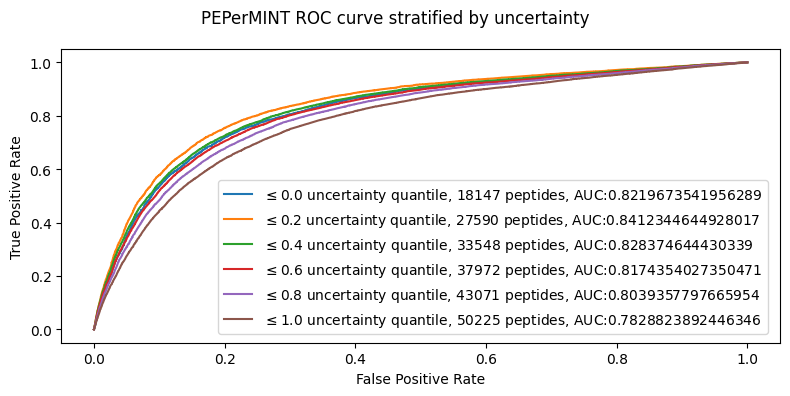

In [6]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
line_types = ['-', '-', '-', '--', '--', '-', '-.', '-.', ':', '-', '--', '-.']

from matplotlib import cm

ds = imp_datasets['maxlfqbench']

numerator_samples = ['H1','H2','H3']
denominator_samples = ['L1','L2','L3']
fc_thresh = 1.5
fdr = 0.05


fig_roc, ax_roc = plt.subplots(1, 1, figsize=(8, 4))
prauc_values = {}
roc_values = {}

for quantile in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    ds = imp_datasets['maxlfqbench'].copy()
    var = ds.values['peptide'].df['gnn_imp_var']
    var.mean(), var.std()
    mat = ds.get_wf('peptide', 'gnn_imp')
    var_mat = ds.get_wf('peptide', 'gnn_imp_var')
    var_mat[var_mat.isna()] = 0
    thresh = var.quantile(quantile)
    vals = ds.values['peptide'].df['gnn_imp']
    vals[var > thresh] = vals.mean()
    ds.values['peptide']['gnn_imp'] = vals
    ids = (var_mat <= thresh).all(axis=1)
    ids = ids[ids].index
    print(ids.shape)
    mols = ds.molecules['peptide']
    ids = ids.intersection(mols.loc[(mols.is_ecoli.astype(int) + mols.is_human.astype(int)) == 1].index)
    #ids = pd.Series(1, index=ids).sample(18000).index

    des, pvalues, fc = find_des(dataset=ds, molecule='peptide', columns=['gnn_imp'],
                                nominator_samples=numerator_samples, denominator_samples=denominator_samples,
                                min_fc=1, max_pvalue=0.05, is_log=True, assume_equal_var=False, ids=ids)
    is_ecoli = ds.molecules['peptide'].is_ecoli
    pvalues = pvalues.loc[ids]
    is_ecoli = is_ecoli.loc[ids]
    categories = pd.Series(index=is_ecoli.index, data='')
    categories.loc[is_ecoli] = 'E. coli'
    categories.loc[~is_ecoli] = 'Human'
    gt_fc = pd.Series(index=categories.index, data=1)
    gt_fc.loc[categories == 'E. coli'] = 3
    gt_fc[gt_fc == 1] = 0
    gt_fc[gt_fc == 3] = 1
    ax = ax_roc
    fpr, tpr, thresholds = roc_curve(y_true=gt_fc, y_score=1 - pvalues['gnn_imp'])
    fdr_coords = np.argmax(thresholds < (1 - fdr)) - 1
    fdr_coords = (fpr[fdr_coords], tpr[fdr_coords])
    a = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'$\leq${quantile} uncertainty quantile, {ids.shape[0]} peptides, AUC:{a}')# color=color, linestyle=line_type, zorder=100-i)
    #ax.plot([fdr_coords[0]], [fdr_coords[1]], marker='o', markersize=5)#, color=color, zorder=1000-i)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

mols = ds.molecules['peptide']
ids = mols.loc[(mols.is_ecoli.astype(int) + mols.is_human.astype(int)) == 1].index
#ids = pd.Series(1, index=ids).sample(18000).index
des, pvalues, fc = find_des(dataset=ds, molecule='peptide', columns=['abundance'],
                            nominator_samples=numerator_samples, denominator_samples=denominator_samples,
                            min_fc=1, max_pvalue=0.05, is_log=True, assume_equal_var=False, ids=ids)
is_ecoli = ds.molecules['peptide'].is_ecoli
pvalues = pvalues.loc[ids]
is_ecoli = is_ecoli.loc[ids]
categories = pd.Series(index=is_ecoli.index, data='')
categories.loc[is_ecoli] = 'E. coli'
categories.loc[~is_ecoli] = 'Human'
gt_fc = pd.Series(index=categories.index, data=1)
gt_fc.loc[categories == 'E. coli'] = 3
gt_fc[gt_fc == 1] = 0
gt_fc[gt_fc == 3] = 1
ax = ax_roc
fpr, tpr, thresholds = roc_curve(y_true=gt_fc, y_score=1 - pvalues['abundance'])
fdr_coords = np.argmax(thresholds < (1 - fdr)) - 1
fdr_coords = (fpr[fdr_coords], tpr[fdr_coords])
a = auc(fpr, tpr)
#ax.plot(fpr, tpr, label=f'without imputation, AUC({a}, peptides:{ids.shape[0]}')# color=color, linestyle=line_type, zorder=100-i)
#ax.plot([fdr_coords[0]], [fdr_coords[1]], marker='o', markersize=5)#, color=color, zorder=1000-i)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

#ax.set_xlim(0, 0.1)
#ax.set_ylim(0, .5)
fig_roc.legend(loc='lower right', bbox_to_anchor=(0.975, 0.15))
fig_roc.suptitle('PEPerMINT ROC curve stratified by uncertainty')
fig_roc.tight_layout()
fig_roc.savefig('figures/roc_stratified_uncertainty.pdf', bbox_inches='tight')

## Runtime

In [103]:
import json

runtimes_dict = json.load(open('data/runtimes.json', 'r'))

In [109]:
runtimes_dict[ds_name]

{'mindet': 0.07680273056030273,
 'minprob': 4.501678705215454,
 'mean': 0.08028483390808105,
 'knn': 1193.3752329349518,
 'missforest': 428.78222036361694,
 'bpca': 1441.2182250022888,
 'isvd': 3.207392930984497,
 'vae': 42.68819189071655,
 'dae': 35.26338481903076,
 'cf': 32.289610624313354,
 'iterative': 10.962323904037476,
 'gnn_imp': 1753.3756601810455,
 'median': 0.13460493087768555}

/tmp/ipykernel_4003644/398677705.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([method_label_map[m.get_text()] for m in ax.get_xticklabels()], rotation=45, ha='right', fontsize=13)
/tmp/ipykernel_4003644/398677705.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([method_label_map[m.get_text()] for m in ax.get_xticklabels()], rotation=45, ha='right', fontsize=13)
/tmp/ipykernel_4003644/398677705.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([method_label_map[m.get_text()] for m in ax.get_xticklabels()], rotation=45, ha='right', fontsize=13)
/tmp/ipykernel_4003644/398677705.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. af

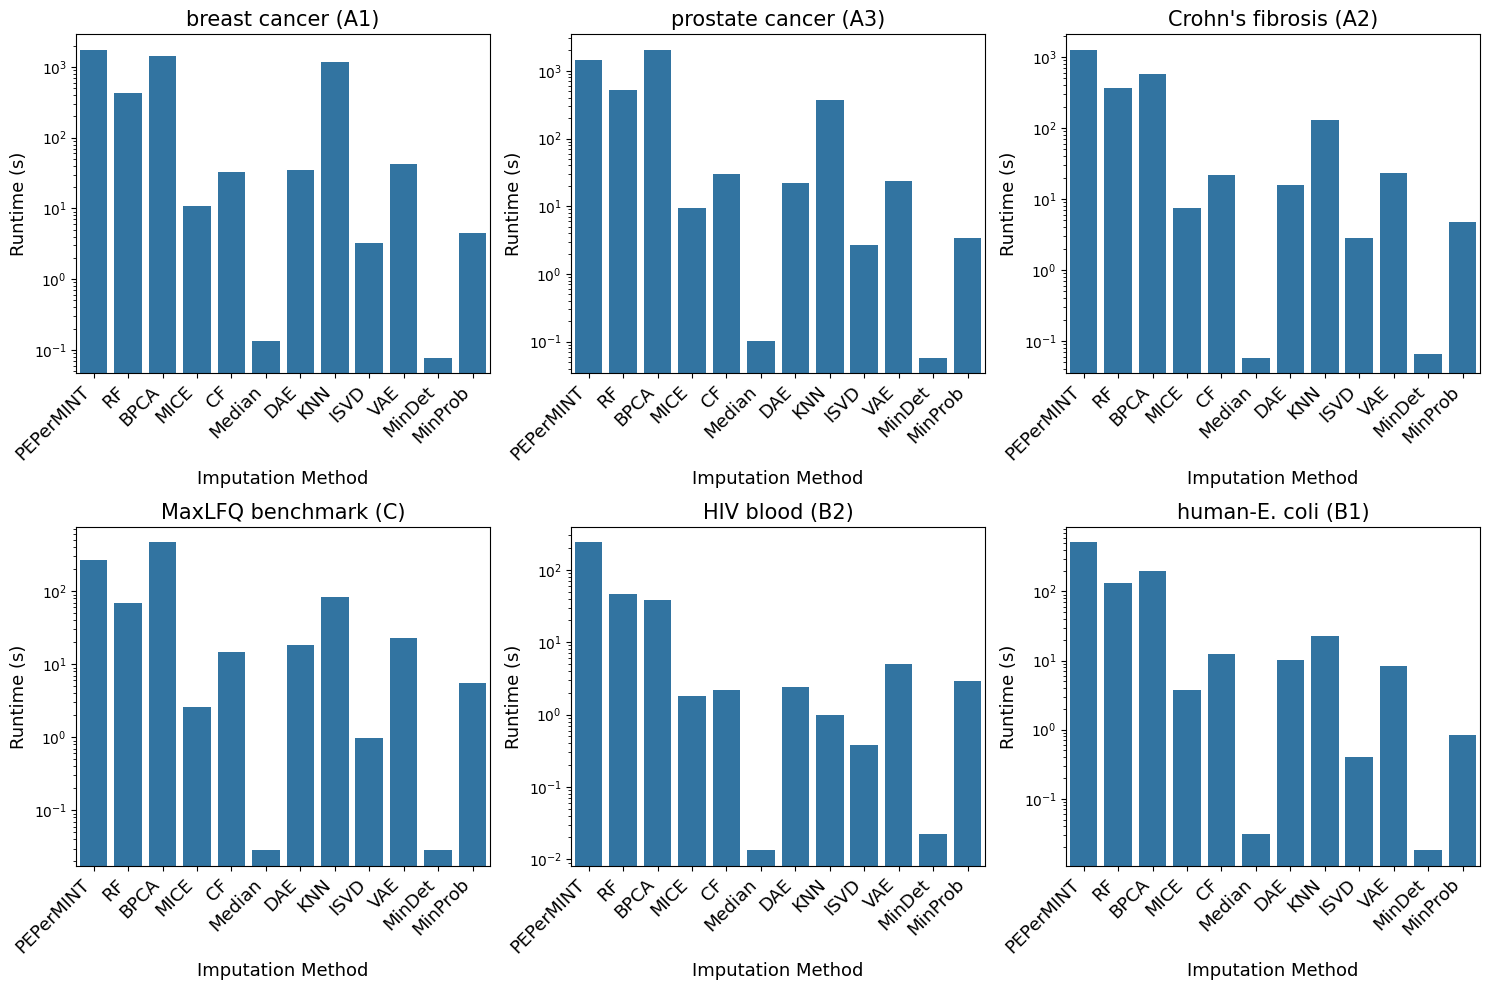

In [139]:
import math

n_ds = len(imp_datasets)
n_cols = math.ceil(n_ds/2)
fig, axs = plt.subplots(2, n_cols, figsize=(n_cols*5, 10))
axs = axs.flatten()
for ds_name, ax in zip(imp_datasets.keys(), axs):
    df = pd.DataFrame({'method': runtimes_dict[ds_name].keys(), 'runtime': runtimes_dict[ds_name].values()},
                       index=[method_label_map[m] for m in runtimes_dict[ds_name].keys()])
    df = df.loc[method_order]
    sns.barplot(data=df, x='method', y='runtime', ax=ax)
    ax.set_yscale('log')
    ax.set_ylabel('Runtime (s)', fontsize=13)
    ax.set_xlabel('Imputation Method', fontsize=13)
    ax.set_xticklabels([method_label_map[m.get_text()] for m in ax.get_xticklabels()], rotation=45, ha='right', fontsize=13)
    ax.set_title(dataset_label_map[ds_name], fontsize=15)
fig.tight_layout()
fig.savefig('figures/runtimes.pdf', bbox_inches='tight')